In [1]:
import pandas as pd
#pd.set_option('display.max_rows', None)
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import numpy as np
np.set_printoptions(threshold=33500)
from shapely.geometry import Polygon, Point, MultiPoint, MultiPolygon, GeometryCollection
from shapely.ops import cascaded_union
import shapely.wkt
from shapely.validation import explain_validity,make_valid
from datetime import datetime, timedelta
from collections import OrderedDict
import fiona
from matplotlib.path import Path
from timezonefinder import TimezoneFinder
import pytz
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
viirs_all = pd.read_csv('merged_viirs.csv', dtype = {'satellite': str,'version': str, 'type': str})

In [3]:
#incidents_all = pd.read_csv('unique_fires.csv')
incidents_all = pd.read_csv('unique_fires_with_area.csv')
incidents_all = pd.concat([incidents_all, pd.DataFrame({'First Day UTC': np.zeros(len(incidents_all)),\
                                                'Last Day UTC': np.zeros(len(incidents_all)),\
                                               'Timezone': np.zeros(len(incidents_all))})], axis=1)
incidents_all['Fire Name'] = incidents_all['Fire Name'].str.upper() # make all fire names upper case so they can be easily searched

#put incident timezones into UTC
#NEED TO DEAL WITH TIME ZONES, based on location and time of year, from here: https://pypi.org/project/pytz/
for ii in range(len(incidents_all)):
    obj=TimezoneFinder() #initialize the timezone finder
    tz = obj.timezone_at(lng=incidents_all['Lon Fire'].iloc[ii], lat=incidents_all['Lat Fire'].iloc[ii]) #get the timezone
    
    local = pytz.timezone(tz)
    utc = pytz.utc
    #put the start and end times in local time
    loc_dt_start = local.localize(datetime.strptime(incidents_all['First Day'].iloc[ii], '%Y-%m-%d %H:%M:%S'))
    loc_dt_end = local.localize(datetime.strptime(incidents_all['Last Day'].iloc[ii], '%Y-%m-%d'))
    #put them in UTC time
    utc_dt_start = loc_dt_start.astimezone(utc)
    utc_dt_end = loc_dt_end.astimezone(utc)
        
    #reassign to UTC time, this DOES keep track of daylight savings (eg +7 is used for PDT, +8 is used for PST)
    incidents_all['First Day UTC'].iloc[ii] = str(utc_dt_start)[0:19]
    incidents_all['Last Day UTC'].iloc[ii] = str(utc_dt_end)[0:19]
    incidents_all['Timezone'].iloc[ii] = tz    
incidents_all

,Incident Number,Fire Name,First Day,Last Day,Lat Fire,Lon Fire,Final Area (ac),First Day UTC,Last Day UTC,Timezone
0,10662156.0,C34,2019-02-13 15:00:00,2019-02-15,36.995278,-102.524722,3812.1,2019-02-13 22:00:00,2019-02-15 07:00:00,America/Denver
1,10662179.0,2161,2019-02-13 16:40:00,2019-02-14,35.221389,-101.518611,400.0,2019-02-13 22:40:00,2019-02-14 06:00:00,America/Chicago
2,10662684.0,PAINTED WAGON,2019-04-08 13:02:00,2019-04-10,33.786944,-112.753333,384.0,2019-04-08 20:02:00,2019-04-10 07:00:00,America/Phoenix
3,10663171.0,LONE MOUNTAIN,2019-05-26 23:56:00,2019-07-03,33.808056,-105.738611,3631.0,2019-05-27 05:56:00,2019-07-03 06:00:00,America/Denver
4,10663525.0,BOULDER,2019-06-05 12:45:00,2019-06-06,35.333056,-119.905556,1127.0,2019-06-05 19:45:00,2019-06-06 07:00:00,America/Los_Angeles
...,...,...,...,...,...,...,...,...,...,...
1350,11979081.0,LAURA 2,2020-11-17 13:30:00,2020-11-23,40.034034,-120.115073,2800.0,2020-11-17 21:30:00,2020-11-23 08:00:00,America/Los_Angeles
1351,11979237.0,TRAIL,2020-10-24 21:32:00,2020-11-02,34.147222,-112.117778,1674.0,2020-10-25 04:32:00,2020-11-02 07:00:00,America/Phoenix
1352,11980186.0,SANDERSON,2020-12-13 03:00:00,2020-12-14,33.889444,-117.070833,1933.0,2020-12-13 11:00:00,2020-12-14 08:00:00,America/Los_Angeles
1353,11980587.0,CREEK 5,2020-12-24 01:22:00,2020-12-28,33.402646,-117.266795,4276.0,2020-12-24 09:22:00,2020-12-28 08:00:00,America/Los_Angeles


# Make sure each detection is getting matched with one fire

In [10]:
allfires = gpd.read_file('AllFires_VIIRS_per_overpass_2019.geojson')
allfires

,Incident Number,Fire Name,Current Day,Current Overpass,Lat Fire,Lon Fire,Number of NEW VIIRS points,NEW FRP,daily_area,geometry
0,10662156.0,C34,2019-02-13,805.0,36.995278,-102.524722,0.0,0.00,26.964312,"POLYGON ((5195031.854 140856.013, 5195027.657 ..."
1,10663171.0,LONE MOUNTAIN,2019-05-27,737.0,33.808056,-105.738611,0.0,0.00,29.284136,"POLYGON ((4813880.922 -172252.832, 4813875.575..."
2,10663171.0,LONE MOUNTAIN,2019-06-09,1953.0,33.808056,-105.738611,2.0,7.73,58.574345,"MULTIPOLYGON (((4814309.507 -172632.006, 48143..."
3,10663171.0,LONE MOUNTAIN,2019-06-13,2019.0,33.808056,-105.738611,4.0,538.78,117.158007,"MULTIPOLYGON (((4813645.457 -172815.386, 48136..."
4,10663171.0,LONE MOUNTAIN,2019-06-21,809.0,33.808056,-105.738611,6.0,7.84,118.831650,"MULTIPOLYGON (((4814676.138 -172252.573, 48146..."
...,...,...,...,...,...,...,...,...,...,...
2564,10805427.0,204 COW,2019-09-15,2100.0,44.285000,-118.459722,5.0,59.14,58.776820,"MULTIPOLYGON (((4094305.831 1342202.992, 40943..."
2565,10806265.0,CHIMNEY CREEK,2019-08-09,746.0,33.323889,-101.080833,0.0,0.00,29.653259,"POLYGON ((5266813.975 -314812.495, 5266810.101..."
2566,10806265.0,CHIMNEY CREEK,2019-08-09,2050.0,33.323889,-101.080833,7.0,355.06,207.746881,"MULTIPOLYGON (((5265998.009 -318632.503, 52659..."
2567,10806265.0,CHIMNEY CREEK,2019-08-10,1851.0,33.323889,-101.080833,6.0,39.62,173.765313,"MULTIPOLYGON (((5264221.275 -319026.657, 52642..."


0    26.964312
dtype: float64


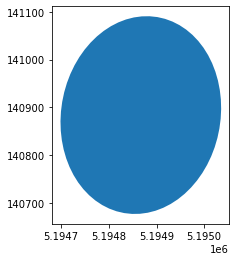

In [38]:
num=0
allfires['geometry'].iloc[num:num+1].plot()
area_one_cell = allfires['geometry'].iloc[num:num+1].area/4047
print(area_one_cell)

2564    58.77682
dtype: float64


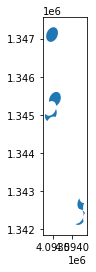

In [46]:
num=2564
allfires['geometry'].iloc[num:num+1].plot()
poly_area = allfires['geometry'].iloc[num:num+1].area/4047
print(poly_area)

In [18]:
days= np.unique(allfires['Current Day'])
overpasses = np.unique(allfires['Current Overpass'])

for day in days:
    for over in overpasses:
        overpass_polys = allfires[(allfires['Current Day']==day) & (allfires['Current Overpass']==over)]
        if len(overpass_polys)>1:
            print(day,over)
            print(overpass_polys)

2019-05-30 818.0
    Incident Number   Fire Name Current Day  Current Overpass   Lat Fire  \
68       10670526.0  WHITE WING  2019-05-30             818.0  33.767778   
71       10670593.0   COLDWATER  2019-05-30             818.0  34.491944   

      Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
68 -112.429167                         0.0      0.0   29.314670   
71 -111.302222                         0.0      0.0   28.770535   

                                             geometry  
68  POLYGON ((4163220.625 3245.479, 4163213.188 32...  
71  POLYGON ((4297482.381 51265.574, 4297475.333 5...  
2019-05-30 2122.0
    Incident Number   Fire Name Current Day  Current Overpass   Lat Fire  \
27       10664827.0      MAROON  2019-05-30            2122.0  35.308889   
70       10670526.0  WHITE WING  2019-05-30            2122.0  33.767778   

      Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
27 -111.407500                         1.0     5.87   28.135246   
70 

2019-06-07 731.0
      Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
869        10732316.0  MOUNTAIN  2019-06-07             731.0  33.870830   
1388       10755614.0    GURULE  2019-06-07             731.0  36.502267   

        Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
869  -111.754200                         0.0      0.0   29.236617   
1388 -106.269433                         0.0      0.0   27.311236   

                                               geometry  
869   POLYGON ((4231676.533 -6193.876, 4231669.309 -...  
1388  POLYGON ((4834037.557 153443.247, 4834032.168 ...  
2019-06-07 912.0
      Incident Number  Fire Name Current Day  Current Overpass   Lat Fire  \
40         10664827.0     MAROON  2019-06-07             912.0  35.308889   
49         10665188.0        ELK  2019-06-07             912.0  33.998990   
83         10670593.0  COLDWATER  2019-06-07             912.0  34.491944   
1305       10750253.0       DEER  2019-06-07   

      Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
55         10665188.0       ELK  2019-06-10             816.0  33.998990   
1209       10747872.0  WOODBURY  2019-06-10             816.0  33.407778   

        Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
55   -108.250800                         1.0     2.04   17.969259   
1209 -111.209722                         4.0    27.71  116.847378   

                                               geometry  
55    POLYGON ((4571777.799 -89668.333, 4571761.785 ...  
1209  MULTIPOLYGON (((4270061.450 -75187.096, 427005...  
2019-06-10 956.0
      Incident Number  Fire Name Current Day  Current Overpass   Lat Fire  \
91         10670593.0  COLDWATER  2019-06-10             956.0  34.491944   
1210       10747872.0   WOODBURY  2019-06-10             956.0  33.407778   

        Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
91   -111.302222                         9.0     9.99  125.375489   
12

2019-06-15 822.0
      Incident Number  Fire Name Current Day  Current Overpass   Lat Fire  \
60         10665188.0        ELK  2019-06-15             822.0  33.998990   
102        10670593.0  COLDWATER  2019-06-15             822.0  34.491944   
1221       10747872.0   WOODBURY  2019-06-15             822.0  33.407778   
1312       10750253.0       DEER  2019-06-15             822.0  33.735278   

        Lon Fire  Number of NEW VIIRS points  NEW FRP   daily_area  \
60   -108.250800                         2.0     1.64    48.010773   
102  -111.302222                         2.0     1.14    46.513865   
1221 -111.209722                        38.0   127.96  1089.984878   
1312 -109.133611                         2.0     1.24    43.739449   

                                               geometry  
60    POLYGON ((4573996.787 -90745.436, 4573996.470 ...  
102   POLYGON ((4289974.616 46824.704, 4289963.694 4...  
1221  MULTIPOLYGON (((4268067.103 -67305.882, 426806...  
1312  MULTIPOL

2019-06-22 931.0
      Incident Number       Fire Name Current Day  Current Overpass  \
1245       10747872.0        WOODBURY  2019-06-22             931.0   
2019       10778148.0  BADGER SPRINGS  2019-06-22             931.0   
2076       10785192.0      PINE LODGE  2019-06-22             931.0   

       Lat Fire    Lon Fire  Number of NEW VIIRS points  NEW FRP   daily_area  \
1245  33.407778 -111.209722                       159.0  1095.82  4061.342859   
2019  34.231389 -112.100278                        10.0    16.63   287.256178   
2076  33.624520 -105.244100                        69.0   127.21   958.801003   

                                               geometry  
1245  MULTIPOLYGON (((4301492.200 -85340.676, 430148...  
2019  MULTIPOLYGON (((4215881.227 47645.695, 4215873...  
2076  MULTIPOLYGON (((4861018.144 -203097.260, 48610...  
2019-06-22 2050.0
      Incident Number       Fire Name Current Day  Current Overpass  \
1246       10747872.0        WOODBURY  2019-06-22   

2019-06-27 2058.0
     Incident Number   Fire Name Current Day  Current Overpass   Lat Fire  \
167       10676253.0  SKULL FLAT  2019-06-27            2058.0  38.282778   
975       10738675.0  DOE CANYON  2019-06-27            2058.0  37.720278   

       Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
167 -112.513333                         5.0    38.41   62.598201   
975 -108.682222                         3.0    17.94   62.288559   

                                              geometry  
167  MULTIPOLYGON (((4328873.040 514585.271, 432887...  
975  MULTIPOLYGON (((4650556.786 348289.267, 465055...  
2019-06-28 918.0
      Incident Number   Fire Name Current Day  Current Overpass   Lat Fire  \
976        10738675.0  DOE CANYON  2019-06-28             918.0  37.720278   
2087       10785192.0  PINE LODGE  2019-06-28             918.0  33.624520   

        Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
976  -108.682222                         2.0     1.80

2019-07-03 925.0
      Incident Number   Fire Name Current Day  Current Overpass   Lat Fire  \
174        10677416.0     WOODROW  2019-07-03             925.0  33.210556   
2163       10790840.0       BLACK  2019-07-03             925.0  33.163540   
2214       10793761.0  BLUE RIVER  2019-07-03             925.0  33.734444   
2221       10793994.0     WHITING  2019-07-03             925.0  34.164167   
2241       10794452.0       SOUTH  2019-07-03             925.0  33.230000   

        Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
174  -108.523889                         1.0     0.52   29.740354   
2163 -107.905300                        12.0    32.25  291.939886   
2214 -109.073333                        13.0    17.78  319.851673   
2221 -109.580556                         5.0     5.93   99.169926   
2241 -107.970278                         4.0     8.20   55.272371   

                                               geometry  
174   POLYGON ((4522218.588 -175249.566, 

2019-07-11 831.0
      Incident Number Fire Name Current Day  Current Overpass  Lat Fire  \
982        10739132.0    NEWMAN  2019-07-11             831.0  35.02250   
1137       10746316.0     SHADY  2019-07-11             831.0  44.51693   

        Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
982  -111.524444                         0.0      0.0   28.378221   
1137 -115.018900                         0.0      0.0   22.136574   

                                               geometry  
982   POLYGON ((4295763.706 118538.575, 4295756.621 ...  
1137  POLYGON ((4364097.782 1263731.559, 4364090.167...  
2019-07-11 835.0
      Incident Number   Fire Name Current Day  Current Overpass   Lat Fire  \
2168       10790840.0       BLACK  2019-07-11             835.0  33.163540   
2219       10793761.0  BLUE RIVER  2019-07-11             835.0  33.734444   
2250       10794452.0       SOUTH  2019-07-11             835.0  33.230000   

        Lon Fire  Number of NEW VIIRS points 

      Incident Number      Fire Name Current Day  Current Overpass   Lat Fire  \
983        10739132.0         NEWMAN  2019-07-15             900.0  35.022500   
2054       10782662.0  WHITE SPRINGS  2019-07-15             900.0  34.206389   

        Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
983  -111.524444                         1.0     0.64   28.368805   
2054 -110.509167                         3.0     4.98   83.144676   

                                               geometry  
983   POLYGON ((4296589.260 119885.304, 4296582.176 ...  
2054  MULTIPOLYGON (((4363338.115 -5441.018, 4363330...  
2019-07-15 2019.0
      Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
984        10739132.0    NEWMAN  2019-07-15            2019.0  35.022500   
1444       10758528.0      DUKE  2019-07-15            2019.0  34.695278   

        Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
984  -111.524444                         9.0   115.74  238

2019-07-18 759.0
     Incident Number           Fire Name Current Day  Current Overpass  \
923       10733380.0  GRASSLANDS COMPLEX  2019-07-18             759.0   
925       10733494.0     REGISTER SPRING  2019-07-18             759.0   
927       10734804.0          COLD CREEK  2019-07-18             759.0   

      Lat Fire    Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
923  37.112778 -102.866111                         0.0      0.0   26.882090   
925  37.111850 -102.918900                         0.0      0.0   26.882722   
927  46.569722 -119.757778                         0.0      0.0   20.949576   

                                              geometry  
923  POLYGON ((5165539.919 160003.048, 5165535.619 ...  
925  POLYGON ((5160605.534 160755.752, 5160601.218 ...  
927  POLYGON ((4108763.239 1623399.750, 4108754.405...  
2019-07-18 943.0
      Incident Number       Fire Name Current Day  Current Overpass  \
515        10712192.0  PEAVINE CANYON  2019-07-18    

2019-07-19 2044.0
      Incident Number     Fire Name Current Day  Current Overpass   Lat Fire  \
451        10709942.0  BRONCO GULCH  2019-07-19            2044.0  33.389167   
993        10739132.0        NEWMAN  2019-07-19            2044.0  35.022500   
2236       10794318.0         RIM 2  2019-07-19            2044.0  33.133889   
2257       10794452.0         SOUTH  2019-07-19            2044.0  33.230000   

        Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
451  -110.138333                         4.0    57.03  107.162806   
993  -111.524444                         2.0    14.46   32.918670   
2236 -109.763333                         1.0     7.33   29.796027   
2257 -107.970278                         1.0     4.76   25.720912   

                                               geometry  
451   MULTIPOLYGON (((4373255.118 -107336.963, 43732...  
993   MULTIPOLYGON (((4296086.990 120964.831, 429607...  
2236  POLYGON ((4401496.637 -150751.139, 4401489.997...  
225

      Incident Number      Fire Name Current Day  Current Overpass   Lat Fire  \
152        10674771.0         MUSEUM  2019-07-22             828.0  35.257778   
855        10729706.0           HART  2019-07-22             828.0  34.532778   
1469       10758566.0         CASTLE  2019-07-22             828.0  36.531160   
2064       10782662.0  WHITE SPRINGS  2019-07-22             828.0  34.206389   

        Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
152  -111.643056                        25.0   741.10  656.491569   
855  -111.191389                         6.0    15.14  101.234115   
1469 -112.228100                         2.0     2.18   20.837926   
2064 -110.509167                         5.0    16.04  120.724674   

                                               geometry  
152   MULTIPOLYGON (((4297353.387 148365.702, 429734...  
855   MULTIPOLYGON (((4312540.950 49315.709, 4312536...  
1469  MULTIPOLYGON (((4285145.423 313808.017, 428515...  
2064  MULTIPOLYG

2019-07-23 1931.0
      Incident Number       Fire Name Current Day  Current Overpass  \
191        10681817.0    SHEEP CANYON  2019-07-23            1931.0   
244        10687307.0          SUMMIT  2019-07-23            1931.0   
247        10687347.0  BUFFALO VALLEY  2019-07-23            1931.0   
1773       10768550.0         BUFFALO  2019-07-23            1931.0   

       Lat Fire    Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
191   40.566111 -117.516111                        22.0   386.89  386.876137   
244   40.655000 -117.339300                        22.0   386.89  386.876137   
247   40.500833 -117.399167                        22.0   386.89  386.876137   
1773  40.696667 -117.366667                        22.0   386.89  386.876137   

                                               geometry  
191   MULTIPOLYGON (((4019907.028 928415.416, 401989...  
244   MULTIPOLYGON (((4019907.028 928415.416, 401989...  
247   MULTIPOLYGON (((4019907.028 928415.416, 40198

2019-07-25 909.0
      Incident Number      Fire Name Current Day  Current Overpass   Lat Fire  \
200        10682164.0     MOSS RANCH  2019-07-25             909.0  47.446667   
1857       10773154.0    BARREN HILL  2019-07-25             909.0  46.236833   
2126       10789235.0      LEFT HAND  2019-07-25             909.0  46.932970   
2176       10791721.0  DESERT CANYON  2019-07-25             909.0  47.707222   

        Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
200  -114.355833                         2.0     2.04   33.085949   
1857 -114.982833                         1.0     0.91    7.459141   
2126 -120.992800                         6.0    33.81  114.354052   
2176 -120.165556                         5.0    12.10  101.519308   

                                               geometry  
200   MULTIPOLYGON (((4527485.528 1554334.914, 45274...  
1857  POLYGON ((4436468.262 1443756.680, 4436460.009...  
2126  MULTIPOLYGON (((4040313.313 1699903.181, 40403...  

2019-07-26 2016.0
      Incident Number    Fire Name Current Day  Current Overpass   Lat Fire  \
1860       10773154.0  BARREN HILL  2019-07-26            2016.0  46.236833   
2185       10791868.0        MP 97  2019-07-26            2016.0  42.913611   

        Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
1860 -114.982833                         1.0     5.46    0.008394   
2185 -123.267500                        54.0  1156.14  793.610304   

                                               geometry  
1860  POLYGON ((4436401.121 1443611.025, 4436392.552...  
2185  MULTIPOLYGON (((3670019.964 1379097.516, 36700...  
2019-07-26 2017.0
      Incident Number   Fire Name Current Day  Current Overpass   Lat Fire  \
203        10682164.0  MOSS RANCH  2019-07-26            2017.0  47.446667   
2131       10789235.0   LEFT HAND  2019-07-26            2017.0  46.932970   

        Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
203  -114.355833                        

2019-07-29 934.0
      Incident Number    Fire Name Current Day  Current Overpass   Lat Fire  \
209        10682164.0   MOSS RANCH  2019-07-29             934.0  47.446667   
1797       10771851.0  NORTH HILLS  2019-07-29             934.0  46.753170   
1864       10773154.0  BARREN HILL  2019-07-29             934.0  46.236833   
2139       10789235.0    LEFT HAND  2019-07-29             934.0  46.932970   

        Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
209  -114.355833                         1.0     1.07    4.157325   
1797 -111.962900                        43.0   243.92  628.024812   
1864 -114.982833                         9.0     8.03  102.825300   
2139 -120.992800                        19.0    27.45   90.784716   

                                               geometry  
209   POLYGON ((4527681.459 1555157.891, 4527674.156...  
1797  MULTIPOLYGON (((4680174.590 1421536.300, 46801...  
1864  MULTIPOLYGON (((4436900.988 1443876.467, 44368...  
2139  MUL

2019-07-30 2038.0
     Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
419       10704000.0    BAGNAL  2019-07-30            2038.0  34.235833   
860       10729706.0      HART  2019-07-30            2038.0  34.532778   

       Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
419 -110.140278                         3.0    32.95   86.876812   
860 -111.191389                         1.0     2.47    0.780748   

                                              geometry  
419  MULTIPOLYGON (((4402505.720 -12273.505, 440249...  
860  MULTIPOLYGON (((4310384.918 47742.914, 4310378...  
2019-07-30 2041.0
      Incident Number      Fire Name Current Day  Current Overpass   Lat Fire  \
1054       10743078.0  GRANITE GULCH  2019-07-30            2041.0  45.178056   
1801       10771851.0    NORTH HILLS  2019-07-30            2041.0  46.753170   
2195       10791868.0          MP 97  2019-07-30            2041.0  42.913611   

        Lon Fire  Number of NEW VIIRS

2019-08-02 2126.0
     Incident Number       Fire Name Current Day  Current Overpass   Lat Fire  \
422       10705159.0         SULPHUR  2019-08-02            2126.0  46.625278   
546       10716356.0  WILLIAMS FLATS  2019-08-02            2126.0  47.939167   

       Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
422 -118.721111                         5.0   166.35  104.565223   
546 -118.618333                        14.0   328.68  231.784866   

                                              geometry  
422  MULTIPOLYGON (((4187929.721 1595041.724, 41879...  
546  MULTIPOLYGON (((4253510.480 1728244.699, 42535...  
2019-08-03 759.0
     Incident Number   Fire Name Current Day  Current Overpass   Lat Fire  \
250       10688140.0  COVE CREEK  2019-08-03             759.0  45.328056   
279       10689266.0  PAINT MINE  2019-08-03             759.0  39.779167   
282       10690091.0       GHOST  2019-08-03             759.0  33.662080   
286       10690272.0  SNOW CREEK  201

      Incident Number       Fire Name Current Day  Current Overpass  \
577        10718522.0             K49  2019-08-05             902.0   
616        10719602.0  163 HK COMPLEX  2019-08-05             902.0   
836        10728734.0        HORSEFLY  2019-08-05             902.0   
1029       10740826.0         SHAFTER  2019-08-05             902.0   
1034       10742174.0           CORTA  2019-08-05             902.0   
1118       10743740.0           GOOSE  2019-08-05             902.0   
1329       10752620.0         RUSSELL  2019-08-05             902.0   
1333       10752668.0          CURLEW  2019-08-05             902.0   

       Lat Fire    Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
577   36.554167 -103.126944                         0.0      0.0   27.274521   
616   45.050278 -119.450833                         0.0      0.0   21.823051   
836   46.962970 -112.440700                         0.0      0.0   20.727684   
1029  40.730833 -114.561389             

      Incident Number       Fire Name Current Day  Current Overpass  \
256        10688140.0      COVE CREEK  2019-08-05            2029.0   
290        10690272.0      SNOW CREEK  2019-08-05            2029.0   
557        10716356.0  WILLIAMS FLATS  2019-08-05            2029.0   
618        10719602.0  163 HK COMPLEX  2019-08-05            2029.0   
837        10728734.0        HORSEFLY  2019-08-05            2029.0   
1067       10743078.0   GRANITE GULCH  2019-08-05            2029.0   
1130       10745077.0         NETHKER  2019-08-05            2029.0   

       Lat Fire    Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
256   45.328056 -114.452778                        13.0   135.09  196.044714   
290   47.703333 -113.400000                         6.0   461.64   59.623060   
557   47.939167 -118.618333                        13.0  1540.13  122.340661   
618   45.050278 -119.450833                         2.0    29.46   43.624582   
837   46.962970 -112.440700    

2019-08-07 824.0
      Incident Number  Fire Name Current Day  Current Overpass   Lat Fire  \
700        10724403.0  PEMBERTON  2019-08-07             824.0  34.718333   
1350       10753522.0   MORRISON  2019-08-07             824.0  35.824444   

        Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
700  -112.680278                         0.0      0.0   28.602489   
1350 -101.015000                         0.0      0.0   27.795100   

                                               geometry  
700   POLYGON ((4175986.682 119622.873, 4175979.226 ...  
1350  POLYGON ((5316450.724 -18714.315, 5316446.962 ...  
2019-08-07 825.0
     Incident Number   Fire Name Current Day  Current Overpass   Lat Fire  \
294       10690272.0  SNOW CREEK  2019-08-07             825.0  47.703333   
841       10728734.0    HORSEFLY  2019-08-07             825.0  46.962970   

     Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
294 -113.4000                        28.0    95.67  39

2019-08-08 2111.0
      Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
1917       10774036.0   SPRINGS  2019-08-08            2111.0  37.825833   
2230       10794216.0      LONE  2019-08-08            2111.0  40.765780   

        Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
1917 -118.872222                         2.0    24.83   25.957715   
2230 -117.218300                        20.0   255.76  488.650251   

                                               geometry  
1917  MULTIPOLYGON (((3757488.436 679599.151, 375747...  
2230  MULTIPOLYGON (((4035418.042 934993.774, 403540...  
2019-08-08 2113.0
     Incident Number       Fire Name Current Day  Current Overpass   Lat Fire  \
300       10690272.0      SNOW CREEK  2019-08-08            2113.0  47.703333   
569       10716356.0  WILLIAMS FLATS  2019-08-08            2113.0  47.939167   

       Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
300 -113.400000                        14

2019-08-11 853.0
      Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
584        10718615.0  TRUMBULL  2019-08-11             853.0  36.411944   
1338       10753199.0     CUEVA  2019-08-11             853.0  36.319444   
1923       10774036.0   SPRINGS  2019-08-11             853.0  37.825833   

        Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
584  -113.141111                         1.0     1.86    4.485841   
1338 -106.801111                         1.0     0.63   27.444508   
1923 -118.872222                        13.0    78.55  152.180302   

                                               geometry  
584   POLYGON ((4198389.757 325164.220, 4198383.995 ...  
1338  POLYGON ((4779494.132 143371.809, 4779488.571 ...  
1923  MULTIPOLYGON (((3757010.981 679546.198, 375700...  
2019-08-11 2013.0
     Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
633       10721378.0    BOULIN  2019-08-11            2013.0  35.392778   
9

2019-08-13 815.0
      Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
587        10718615.0  TRUMBULL  2019-08-13             815.0  36.411944   
638        10721378.0    BOULIN  2019-08-13             815.0  35.392778   
1496       10758566.0    CASTLE  2019-08-13             815.0  36.531160   

        Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
587  -113.141111                         1.0     0.81   27.377964   
638  -112.010833                         4.0     9.08   52.792255   
1496 -112.228100                         5.0    14.11   63.364221   

                                               geometry  
587   POLYGON ((4199449.788 324589.131, 4199442.296 ...  
638   MULTIPOLYGON (((4264476.998 174970.178, 426446...  
1496  MULTIPOLYGON (((4281906.069 306691.160, 428189...  
2019-08-13 956.0
      Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
588        10718615.0  TRUMBULL  2019-08-13             956.0  36.411944   


2019-08-14 2057.0
      Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
642        10721378.0    BOULIN  2019-08-14            2057.0  35.392778   
1006       10740649.0     SABER  2019-08-14            2057.0  35.010278   
1624       10764037.0      IKES  2019-08-14            2057.0  36.347930   

        Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
642  -112.010833                         1.0    13.33   18.649987   
1006 -111.901389                         4.0    60.60   70.326122   
1624 -112.285600                        10.0    74.18  216.967555   

                                               geometry  
642   POLYGON ((4262716.867 176093.149, 4262708.110 ...  
1006  MULTIPOLYGON (((4260531.124 129962.925, 426052...  
1624  MULTIPOLYGON (((4278880.715 292643.998, 427888...  
2019-08-14 2058.0
      Incident Number    Fire Name Current Day  Current Overpass   Lat Fire  \
874        10732610.0  LITTLE BEAR  2019-08-14            2058.0  37.58

2019-08-16 856.0
      Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
932        10736177.0  MAYFIELD  2019-08-16             856.0  43.451667   
1768       10765981.0    GAINES  2019-08-16             856.0  37.535833   

        Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
932  -115.943333                         0.0      0.0   22.772465   
1768 -120.176944                         0.0      0.0   26.588520   

                                               geometry  
932   POLYGON ((4249527.338 1178461.746, 4249519.410...  
1768  POLYGON ((3632883.217 701098.212, 3632873.740 ...  
2019-08-16 859.0
      Incident Number       Fire Name Current Day  Current Overpass  \
411        10702676.0     WOOD CANYON  2019-08-16             859.0   
535        10712192.0  PEAVINE CANYON  2019-08-16             859.0   
593        10718615.0        TRUMBULL  2019-08-16             859.0   
877        10732610.0     LITTLE BEAR  2019-08-16             859.0   


2019-08-17 838.0
     Incident Number     Fire Name Current Day  Current Overpass  Lat Fire  \
339       10695763.0  BOULDER LAKE  2019-08-17             838.0  42.85445   
721       10725393.0      MCCLUSKY  2019-08-17             838.0  46.01439   

     Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
339 -109.7041                         0.0      0.0   23.135217   
721 -112.2772                         0.0      0.0   21.265860   

                                              geometry  
339  POLYGON ((4720388.455 945553.880, 4720382.305 ...  
721  POLYGON ((4626813.716 1349582.105, 4626806.950...  
2019-08-17 840.0
      Incident Number    Fire Name Current Day  Current Overpass   Lat Fire  \
595        10718615.0     TRUMBULL  2019-08-17             840.0  36.411944   
879        10732610.0  LITTLE BEAR  2019-08-17             840.0  37.588611   
1506       10758566.0       CASTLE  2019-08-17             840.0  36.531160   
1629       10764037.0         IKES  2019-08-1

2019-08-18 1942.0
      Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
600        10718615.0  TRUMBULL  2019-08-18            1942.0  36.411944   
652        10721378.0    BOULIN  2019-08-18            1942.0  35.392778   
1012       10740649.0     SABER  2019-08-18            1942.0  35.010278   
1342       10753199.0     CUEVA  2019-08-18            1942.0  36.319444   
1512       10758566.0    CASTLE  2019-08-18            1942.0  36.531160   
1634       10764037.0      IKES  2019-08-18            1942.0  36.347930   

        Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
600  -113.141111                         1.0    43.88   11.900389   
652  -112.010833                        10.0    87.54  240.657980   
1012 -111.901389                        18.0   173.96  370.797772   
1342 -106.801111                         1.0     2.29   27.447514   
1512 -112.228100                        11.0    66.07  119.141372   
1634 -112.285600                   

2019-08-19 2103.0
      Incident Number  Fire Name Current Day  Current Overpass   Lat Fire  \
711        10724403.0  PEMBERTON  2019-08-19            2103.0  34.718333   
767        10726669.0   SHERIDAN  2019-08-19            2103.0  34.677778   
1016       10740649.0      SABER  2019-08-19            2103.0  35.010278   

        Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
711  -112.680278                         2.0   247.11   57.178598   
767  -112.890278                         2.0   247.11   57.178598   
1016 -111.901389                        19.0   731.59  254.572757   

                                               geometry  
711   MULTIPOLYGON (((4156212.645 128914.002, 415620...  
767   MULTIPOLYGON (((4156212.645 128914.002, 415620...  
1016  MULTIPOLYGON (((4262525.337 129608.992, 426253...  
2019-08-19 2104.0
      Incident Number       Fire Name Current Day  Current Overpass  \
540        10712192.0  PEAVINE CANYON  2019-08-19            2104.0   
603 

2019-08-20 2044.0
     Incident Number  Fire Name Current Day  Current Overpass   Lat Fire  \
713       10724403.0  PEMBERTON  2019-08-20            2044.0  34.718333   
769       10726669.0   SHERIDAN  2019-08-20            2044.0  34.677778   

       Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
713 -112.680278                        12.0   551.94  312.741275   
769 -112.890278                        12.0   551.94  312.741275   

                                              geometry  
713  MULTIPOLYGON (((4157123.404 129825.744, 415711...  
769  MULTIPOLYGON (((4157123.404 129825.744, 415711...  
2019-08-20 2045.0
      Incident Number     Fire Name Current Day  Current Overpass   Lat Fire  \
367        10699801.0  CLAUSON FIRE  2019-08-20            2045.0  36.718889   
605        10718615.0      TRUMBULL  2019-08-20            2045.0  36.411944   
657        10721378.0        BOULIN  2019-08-20            2045.0  35.392778   
889        10732610.0   LITTLE BEAR  20

2019-08-21 2026.0
      Incident Number      Fire Name Current Day  Current Overpass   Lat Fire  \
607        10718615.0       TRUMBULL  2019-08-21            2026.0  36.411944   
668        10722086.0  TRIPLE NICKLE  2019-08-21            2026.0  35.345390   
715        10724403.0      PEMBERTON  2019-08-21            2026.0  34.718333   
771        10726669.0       SHERIDAN  2019-08-21            2026.0  34.677778   
891        10732610.0    LITTLE BEAR  2019-08-21            2026.0  37.588611   
1020       10740649.0          SABER  2019-08-21            2026.0  35.010278   
1520       10758566.0         CASTLE  2019-08-21            2026.0  36.531160   
1641       10764037.0           IKES  2019-08-21            2026.0  36.347930   
1818       10772403.0            COW  2019-08-21            2026.0  36.283889   

        Lon Fire  Number of NEW VIIRS points  NEW FRP   daily_area  \
607  -113.141111                         2.0    24.30    14.825226   
668  -107.527100               

2019-08-22 2007.0
      Incident Number      Fire Name Current Day  Current Overpass   Lat Fire  \
669        10722086.0  TRIPLE NICKLE  2019-08-22            2007.0  35.345390   
718        10724403.0      PEMBERTON  2019-08-22            2007.0  34.718333   
774        10726669.0       SHERIDAN  2019-08-22            2007.0  34.677778   
1022       10740649.0          SABER  2019-08-22            2007.0  35.010278   
1346       10753199.0          CUEVA  2019-08-22            2007.0  36.319444   
1522       10758566.0         CASTLE  2019-08-22            2007.0  36.531160   
1644       10764037.0           IKES  2019-08-22            2007.0  36.347930   

        Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
669  -107.527100                         7.0   150.26  195.677535   
718  -112.680278                        23.0   986.13  451.730215   
774  -112.890278                        23.0   986.13  451.730215   
1022 -111.901389                        23.0   728.32  33

2019-08-24 807.0
      Incident Number       Fire Name Current Day  Current Overpass  Lat Fire  \
1392       10755951.0  PEDRO MOUNTAIN  2019-08-24             807.0  42.34927   
1424       10756529.0     LONG VALLEY  2019-08-24             807.0  39.87968   

      Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
1392 -106.8966                         0.0      0.0   23.445838   
1424 -120.0254                         0.0      0.0   25.014885   

                                               geometry  
1392  POLYGON ((4934996.799 829087.328, 4934991.465 ...  
1424  POLYGON ((3763076.837 942569.732, 3763067.557 ...  
2019-08-24 948.0
      Incident Number       Fire Name Current Day  Current Overpass  \
628        10719602.0  163 HK COMPLEX  2019-08-24             948.0   
1174       10746316.0           SHADY  2019-08-24             948.0   
2523       10805427.0         204 COW  2019-08-24             948.0   

       Lat Fire    Lon Fire  Number of NEW VIIRS points  NEW 

2019-08-25 2051.0
      Incident Number      Fire Name Current Day  Current Overpass   Lat Fire  \
675        10722086.0  TRIPLE NICKLE  2019-08-25            2051.0  35.345390   
781        10726669.0       SHERIDAN  2019-08-25            2051.0  34.677778   
1652       10764037.0           IKES  2019-08-25            2051.0  36.347930   
1825       10772403.0            COW  2019-08-25            2051.0  36.283889   

        Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
675  -107.527100                         9.0    60.45   75.475514   
781  -112.890278                        10.0   129.57  208.555184   
1652 -112.285600                         6.0    90.44   32.867157   
1825 -118.227500                        14.0   387.25  143.348232   

                                               geometry  
675   MULTIPOLYGON (((4682072.174 45198.576, 4682072...  
781   MULTIPOLYGON (((4157262.839 135052.330, 415725...  
1652  MULTIPOLYGON (((4271887.590 290513.385, 427187... 

2019-08-27 851.0
      Incident Number       Fire Name Current Day  Current Overpass  Lat Fire  \
1183       10746316.0           SHADY  2019-08-27             851.0  44.51693   
1400       10755951.0  PEDRO MOUNTAIN  2019-08-27             851.0  42.34927   
2532       10805427.0         204 COW  2019-08-27             851.0  44.28500   

        Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
1183 -115.018900                         1.0     0.95   14.209126   
1400 -106.896600                        18.0    41.45  345.797312   
2532 -118.459722                        26.0    38.55  262.476589   

                                               geometry  
1183  POLYGON ((4361690.434 1265636.602, 4361682.809...  
1400  MULTIPOLYGON (((4936975.561 826826.512, 493697...  
2532  MULTIPOLYGON (((4098731.393 1343833.931, 40987...  
2019-08-27 853.0
      Incident Number      Fire Name Current Day  Current Overpass   Lat Fire  \
678        10722086.0  TRIPLE NICKLE  2019-08-27   

2019-08-28 1955.0
      Incident Number       Fire Name Current Day  Current Overpass  \
543        10712192.0  PEAVINE CANYON  2019-08-28            1955.0   
1659       10764037.0            IKES  2019-08-28            1955.0   
1834       10772403.0             COW  2019-08-28            1955.0   
1908       10773759.0   POISON CANYON  2019-08-28            1955.0   

       Lat Fire    Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
543   37.716667 -109.850000                         3.0    21.02   65.054207   
1659  36.347930 -112.285600                         6.0    65.86   53.330342   
1834  36.283889 -118.227500                         4.0    27.21   59.864651   
1908  37.834444 -109.799444                         3.0    21.02   65.054207   

                                               geometry  
543   MULTIPOLYGON (((4550721.439 385854.541, 455071...  
1659  MULTIPOLYGON (((4270745.433 292980.284, 427073...  
1834  POLYGON ((3740789.894 491331.904, 3740793.018

2019-08-29 2116.0
     Incident Number      Fire Name Current Day  Current Overpass   Lat Fire  \
684       10722086.0  TRIPLE NICKLE  2019-08-29            2116.0  35.345390   
789       10726669.0       SHERIDAN  2019-08-29            2116.0  34.677778   

       Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
684 -107.527100                        11.0   185.58  235.319684   
789 -112.890278                         6.0    24.99  166.825913   

                                              geometry  
684  MULTIPOLYGON (((4681410.930 47359.907, 4681405...  
789  MULTIPOLYGON (((4163377.417 137513.422, 416336...  
2019-08-29 2117.0
      Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
1837       10772403.0       COW  2019-08-29            2117.0  36.283889   
1969       10774036.0   SPRINGS  2019-08-29            2117.0  37.825833   

        Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
1837 -118.227500                         5.0    8

2019-08-31 2038.0
      Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
793        10726669.0  SHERIDAN  2019-08-31            2038.0  34.677778   
2295       10796736.0  CHAMPION  2019-08-31            2038.0  33.500000   

        Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
793  -112.890278                        15.0   317.54  242.798404   
2295 -110.621667                         5.0   134.70  147.559366   

                                               geometry  
793   MULTIPOLYGON (((4152503.391 131809.113, 415250...  
2295  MULTIPOLYGON (((4327616.412 -82118.305, 432760...  
2019-08-31 2039.0
      Incident Number    Fire Name Current Day  Current Overpass   Lat Fire  \
912        10732610.0  LITTLE BEAR  2019-08-31            2039.0  37.588611   
1663       10764037.0         IKES  2019-08-31            2039.0  36.347930   
1841       10772403.0          COW  2019-08-31            2039.0  36.283889   
1974       10774036.0      SPRINGS  2

      Incident Number   Fire Name Current Day  Current Overpass   Lat Fire  \
1989       10775474.0  STUCKEY RD  2019-09-02             837.0  47.606111   
1991       10775504.0      CHERRY  2019-09-02             837.0  40.066510   
1995       10775726.0       AMOLE  2019-09-02             837.0  36.200278   
2001       10776015.0    FISHHAWK  2019-09-02             837.0  44.376667   

        Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
1989 -111.341944                         0.0      0.0   20.368300   
1991 -115.645900                         0.0      0.0   24.893140   
1995 -105.595278                         0.0      0.0   27.525811   
2001 -109.880833                         0.0      0.0   22.219191   

                                               geometry  
1989  POLYGON ((4750399.482 1497215.110, 4750393.047...  
1991  POLYGON ((4130434.745 807272.563, 4130426.722 ...  
1995  POLYGON ((4889291.175 104309.810, 4889285.983 ...  
2001  POLYGON ((4754529.296 111

2019-09-03 1944.0
      Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
1994       10775504.0    CHERRY  2019-09-03            1944.0  40.066510   
2004       10776015.0  FISHHAWK  2019-09-03            1944.0  44.376667   

        Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
1994 -115.645900                         1.0     6.02   13.646248   
2004 -109.880833                        12.0   296.69  156.749980   

                                               geometry  
1994  POLYGON ((4132136.449 810493.666, 4132128.430 ...  
2004  MULTIPOLYGON (((4772396.158 1140051.506, 47723...  
2019-09-03 1945.0
      Incident Number      Fire Name Current Day  Current Overpass   Lat Fire  \
748        10725393.0       MCCLUSKY  2019-09-03            1945.0  46.014390   
1104       10743078.0  GRANITE GULCH  2019-09-03            1945.0  45.178056   
2554       10805427.0        204 COW  2019-09-03            1945.0  44.285000   

        Lon Fire  Number of 

2019-09-05 740.0
      Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
327        10694867.0      LIME  2019-09-05             740.0  41.865833   
937        10737474.0     ROCKY  2019-09-05             740.0  34.298800   
2095       10786072.0   TABOOSE  2019-09-05             740.0  37.034167   
2311       10797188.0     SOUTH  2019-09-05             740.0  40.108889   
2365       10798998.0      HUNT  2019-09-05             740.0  39.752778   
2392       10800162.0  RED BANK  2019-09-05             740.0  40.120000   
2419       10800977.0    MIDDLE  2019-09-05             740.0  40.887080   
2502       10804162.0    TENAJA  2019-09-05             740.0  33.528469   

        Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
327  -122.670278                         0.0      0.0   23.746156   
937  -110.632400                         0.0      0.0   28.914678   
2095 -118.345278                         0.0      0.0   26.937050   
2311 -122.788889      

2019-09-06 902.0
      Incident Number Fire Name Current Day  Current Overpass  Lat Fire  \
413        10703662.0  FLAT TOP  2019-09-06             902.0  42.99344   
2360       10798629.0      LONE  2019-09-06             902.0  41.74760   
2384       10799221.0      NECK  2019-09-06             902.0  38.00267   

      Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
413  -113.1113                         0.0      0.0   23.050403   
2360 -121.0557                         0.0      0.0   23.820119   
2384 -113.1516                         0.0      0.0   26.268236   

                                               geometry  
413   POLYGON ((4452638.932 1047140.348, 4452631.793...  
2360  POLYGON ((3775684.123 1176122.675, 3775674.673...  
2384  POLYGON ((4259793.525 502765.674, 4259786.118 ...  
2019-09-06 904.0
      Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
329        10694867.0      LIME  2019-09-06             904.0  41.865833   
414        1

      Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
2316       10797188.0     SOUTH  2019-09-06            2208.0  40.108889   
2397       10800162.0  RED BANK  2019-09-06            2208.0  40.120000   
2421       10800977.0    MIDDLE  2019-09-06            2208.0  40.887080   
2459       10802166.0    WALKER  2019-09-06            2208.0  40.053333   

        Lon Fire  Number of NEW VIIRS points   NEW FRP   daily_area  \
2316 -122.788889                        17.0    660.04   292.046376   
2397 -122.640000                        61.0   1642.81   963.204794   
2421 -123.013900                         6.0     64.46    64.292247   
2459 -120.668889                       266.0  41925.40  4370.171605   

                                               geometry  
2316  MULTIPOLYGON (((3556895.067 1077389.522, 35568...  
2397  MULTIPOLYGON (((3568787.498 1073967.009, 35687...  
2421  POLYGON ((3578879.174 1165696.854, 3578870.796...  
2459  MULTIPOLYGON (((3733781.0

      Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
1675       10764037.0      IKES  2019-09-08            1008.0  36.347930   
2319       10797188.0     SOUTH  2019-09-08            1008.0  40.108889   
2401       10800162.0  RED BANK  2019-09-08            1008.0  40.120000   
2424       10800977.0    MIDDLE  2019-09-08            1008.0  40.887080   
2462       10802166.0    WALKER  2019-09-08            1008.0  40.053333   

        Lon Fire  Number of NEW VIIRS points  NEW FRP    daily_area  \
1675 -112.285600                         4.0     4.00     27.018612   
2319 -122.788889                        20.0    37.88    275.669057   
2401 -122.640000                        22.0    64.01    273.064177   
2424 -123.013900                         6.0     7.53     75.834657   
2462 -120.668889                       486.0  2688.72  10185.949034   

                                               geometry  
1675  MULTIPOLYGON (((4269912.239 292989.353, 426990...  


2019-09-09 2110.0
      Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
938        10737474.0     ROCKY  2019-09-09            2110.0  34.298800   
1679       10764037.0      IKES  2019-09-09            2110.0  36.347930   
1848       10772403.0       COW  2019-09-09            2110.0  36.283889   
2101       10786072.0   TABOOSE  2019-09-09            2110.0  37.034167   

        Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
938  -110.632400                        10.0   109.42  281.743695   
1679 -112.285600                         2.0     9.37    6.163172   
1848 -118.227500                         6.0    51.44   66.907015   
2101 -118.345278                         9.0   383.89   59.746217   

                                               geometry  
938   MULTIPOLYGON (((4360425.311 10100.515, 4360418...  
1679  MULTIPOLYGON (((4269134.377 293466.800, 426913...  
1848  MULTIPOLYGON (((3743091.019 488848.288, 374308...  
2101  MULTIPOLYGON (((3

2019-09-11 2032.0
      Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
797        10726669.0  SHERIDAN  2019-09-11            2032.0  34.677778   
1751       10765433.0   WHISKEY  2019-09-11            2032.0  35.044160   

        Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
797  -112.890278                         3.0    39.65   85.438506   
1751 -111.839900                         4.0    37.64   93.486996   

                                               geometry  
797   MULTIPOLYGON (((4151566.023 129846.214, 415156...  
1751  MULTIPOLYGON (((4266548.795 130823.558, 426654...  
2019-09-11 2034.0
      Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
2328       10797188.0     SOUTH  2019-09-11            2034.0  40.108889   
2411       10800162.0  RED BANK  2019-09-11            2034.0  40.120000   
2472       10802166.0    WALKER  2019-09-11            2034.0  40.053333   

        Lon Fire  Number of NEW VIIRS points  NE

2019-09-13 1954.0
      Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
800        10726669.0  SHERIDAN  2019-09-13            1954.0  34.677778   
825        10727816.0      EDEN  2019-09-13            1954.0  34.632500   
945        10737474.0     ROCKY  2019-09-13            1954.0  34.298800   
1757       10765433.0   WHISKEY  2019-09-13            1954.0  35.044160   
2000       10775726.0     AMOLE  2019-09-13            1954.0  36.200278   

        Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
800  -112.890278                         7.0  1186.89  141.676160   
825  -111.271111                        12.0   102.86  297.626432   
945  -110.632400                        25.0   313.09  329.050601   
1757 -111.839900                        16.0   570.87  230.176436   
2000 -105.595278                         4.0    27.27   76.326309   

                                               geometry  
800   MULTIPOLYGON (((4153935.107 132136.842, 415392

2019-09-15 936.0
      Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
1550       10760280.0    DECKER  2019-09-15             936.0  38.409444   
2338       10797188.0     SOUTH  2019-09-15             936.0  40.108889   
2434       10800977.0    MIDDLE  2019-09-15             936.0  40.887080   
2482       10802166.0    WALKER  2019-09-15             936.0  40.053333   

        Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
1550 -106.003889                         7.0    13.61   64.567101   
2338 -122.788889                        19.0    34.79  266.803492   
2434 -123.013900                         3.0     9.40   55.883102   
2482 -120.668889                        71.0   265.88  381.047032   

                                               geometry  
1550  MULTIPOLYGON (((4909416.098 367965.823, 490941...  
2338  MULTIPOLYGON (((3553575.441 1078693.096, 35535...  
2434  MULTIPOLYGON (((3578628.786 1164238.040, 35786...  
2482  MULTIPOLYGON (((37

2019-09-20 2103.0
     Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
804       10726669.0  SHERIDAN  2019-09-20            2103.0  34.677778   
959       10737474.0     ROCKY  2019-09-20            2103.0  34.298800   

       Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
804 -112.890278                         2.0    33.33   57.289025   
959 -110.632400                        25.0   477.94  169.760419   

                                              geometry  
804  MULTIPOLYGON (((4185075.895 102610.594, 418506...  
959  MULTIPOLYGON (((4359202.291 7673.590, 4359201....  
2019-09-21 925.0
      Incident Number  Fire Name Current Day  Current Overpass   Lat Fire  \
829        10727816.0       EDEN  2019-09-21             925.0  34.632500   
960        10737474.0      ROCKY  2019-09-21             925.0  34.298800   
1693       10764037.0       IKES  2019-09-21             925.0  36.347930   
2493       10803661.0  TELEPHONE  2019-09-21           

KeyboardInterrupt: 

# Make the polygons for all the incidents

In [18]:
incidents_all = incidents_all[incidents_all['Final Area (ac)']>1000].reset_index() #filter to greater than 1000
incidents_all

,index,Incident Number,Fire Name,First Day,Last Day,Lat Fire,Lon Fire,Final Area (ac),First Day UTC,Last Day UTC,Timezone
0,0,10662156.0,C34,2019-02-13 15:00:00,2019-02-15,36.995278,-102.524722,3812.1,2019-02-13 22:00:00,2019-02-15 07:00:00,America/Denver
1,3,10663171.0,LONE MOUNTAIN,2019-05-26 23:56:00,2019-07-03,33.808056,-105.738611,3631.0,2019-05-27 05:56:00,2019-07-03 06:00:00,America/Denver
2,4,10663525.0,BOULDER,2019-06-05 12:45:00,2019-06-06,35.333056,-119.905556,1127.0,2019-06-05 19:45:00,2019-06-06 07:00:00,America/Los_Angeles
3,6,10663845.0,CHANNING,2019-02-16 18:18:00,2019-02-17,35.655339,-102.323656,7527.4,2019-02-17 00:18:00,2019-02-17 06:00:00,America/Chicago
4,7,10664053.0,KEOTA,2019-03-19 16:30:00,2019-03-20,40.684350,-103.988300,1028.0,2019-03-19 22:30:00,2019-03-20 06:00:00,America/Denver
...,...,...,...,...,...,...,...,...,...,...,...
592,1346,11978031.0,LESLIE GULCH,2020-11-05 16:11:00,2020-11-16,43.330020,-117.222300,5145.0,2020-11-05 23:11:00,2020-11-16 07:00:00,America/Boise
593,1350,11979081.0,LAURA 2,2020-11-17 13:30:00,2020-11-23,40.034034,-120.115073,2800.0,2020-11-17 21:30:00,2020-11-23 08:00:00,America/Los_Angeles
594,1351,11979237.0,TRAIL,2020-10-24 21:32:00,2020-11-02,34.147222,-112.117778,1674.0,2020-10-25 04:32:00,2020-11-02 07:00:00,America/Phoenix
595,1352,11980186.0,SANDERSON,2020-12-13 03:00:00,2020-12-14,33.889444,-117.070833,1933.0,2020-12-13 11:00:00,2020-12-14 08:00:00,America/Los_Angeles


In [19]:
first_days=np.array(incidents_all['First Day'].values, dtype='datetime64')
incidents_all = incidents_all[first_days>np.datetime64('2020-01-01')]

#incidents_all = incidents_all[incidents_all['Fire Name']==['VILLEGREEN FIRE','BIGHORN']]
#incidents_all = incidents_all[incidents_all['Fire Name']=='BIGHORN']

incidents_all

,index,Incident Number,Fire Name,First Day,Last Day,Lat Fire,Lon Fire,Final Area (ac),First Day UTC,Last Day UTC,Timezone
209,540,11683870.0,WEST 380,2020-01-09 15:35:00,2020-01-10,33.270833,-103.403611,1689.0,2020-01-09 22:35:00,2020-01-10 07:00:00,America/Denver
210,542,11687777.0,EAGLE ROCK ROAD,2020-02-01 14:45:00,2020-02-03,47.308056,-110.673889,2700.0,2020-02-01 21:45:00,2020-02-03 07:00:00,America/Denver
211,544,11687821.0,LODE ROAD,2020-02-01 18:15:00,2020-02-06,46.555278,-109.923333,3680.0,2020-02-02 01:15:00,2020-02-06 07:00:00,America/Denver
212,545,11687977.0,LOST LAKE,2020-02-01 11:30:00,2020-02-03,47.648889,-110.471111,1041.0,2020-02-01 18:30:00,2020-02-03 07:00:00,America/Denver
213,546,11690273.0,BENT FORT,2020-04-11 15:19:00,2020-04-13,38.055278,-103.406944,1500.0,2020-04-11 21:19:00,2020-04-13 06:00:00,America/Denver
...,...,...,...,...,...,...,...,...,...,...,...
592,1346,11978031.0,LESLIE GULCH,2020-11-05 16:11:00,2020-11-16,43.330020,-117.222300,5145.0,2020-11-05 23:11:00,2020-11-16 07:00:00,America/Boise
593,1350,11979081.0,LAURA 2,2020-11-17 13:30:00,2020-11-23,40.034034,-120.115073,2800.0,2020-11-17 21:30:00,2020-11-23 08:00:00,America/Los_Angeles
594,1351,11979237.0,TRAIL,2020-10-24 21:32:00,2020-11-02,34.147222,-112.117778,1674.0,2020-10-25 04:32:00,2020-11-02 07:00:00,America/Phoenix
595,1352,11980186.0,SANDERSON,2020-12-13 03:00:00,2020-12-14,33.889444,-117.070833,1933.0,2020-12-13 11:00:00,2020-12-14 08:00:00,America/Los_Angeles


[11683870. 11687777. 11687821. 11687977. 11690273. 11692207. 11694721.
 11702004. 11702184. 11703898. 11705534. 11705882. 11706093. 11706760.
 11707815. 11707842. 11708995. 11710471. 11710986. 11711085. 11711119.
 11711537. 11711845. 11711903. 11712592. 11713776. 11714310. 11714409.
 11714462. 11714572. 11714957. 11715478. 11715591. 11716626. 11717396.
 11717541. 11717874. 11718294. 11718507. 11719259. 11719463. 11719716.
 11721009. 11721706. 11722418. 11723044. 11723968. 11724173. 11724284.
 11724646. 11724989. 11727168. 11727337. 11727780. 11727955. 11728235.
 11728444. 11728691. 11730528. 11731589. 11731887. 11731957. 11732644.
 11732798. 11733300. 11734086. 11734308. 11734453. 11734551. 11734621.
 11734793. 11734875. 11734918. 11735312. 11735669. 11735968. 11736184.
 11738676. 11739308. 11739380. 11739672. 11739703. 11740185. 11745193.
 11745616. 11745720. 11746213. 11746689. 11747621. 11747860. 11748094.
 11748440. 11749246. 11749823. 11749951. 11750632. 11750885. 11751160.
 11751

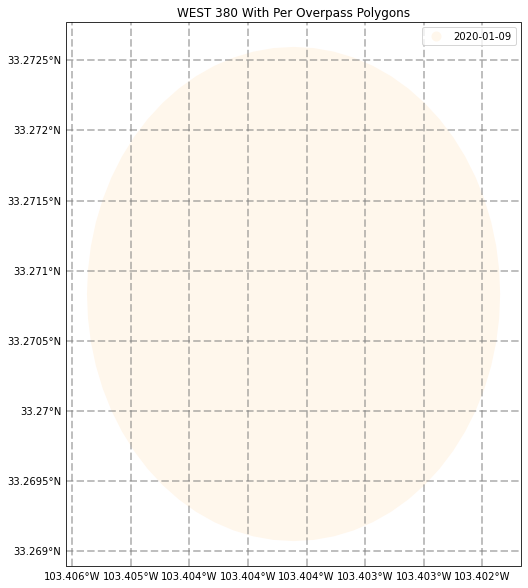

   Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
0       11683870.0  WEST 380  2020-01-09             820.0  33.270833   

     Lon Fire  Number of NEW VIIRS points  NEW FRP  \
0 -103.403611                         0.0      0.0   

                                            geometry  daily_area  
0  POLYGON ((5032687.006 -282796.296, 5032682.381...   29.693992  
EAGLE ROCK ROAD
<class 'str'>
0
['2020-02-01' '2020-02-02' '2020-02-03']
2020-02-01
2020-02-02
2020-02-03
0 seconds seconds elapsed
Valid Geometry
20.53437080428263 2700.0
1
['2020-02-01' '2020-02-02' '2020-02-03']
2020-02-01
2020-02-02
2020-02-03
0 seconds seconds elapsed
Valid Geometry
Valid Geometry
224.6972027037179 2700.0
2
['2020-02-01' '2020-02-02' '2020-02-03']
2020-02-01
2020-02-02
2020-02-03
0 seconds seconds elapsed
Valid Geometry
Valid Geometry
224.6972027037179 2700.0
3
['2020-02-01' '2020-02-02' '2020-02-03']
2020-02-01
2020-02-02
2020-02-03
1 seconds seconds elapsed
Valid Geometry
Valid G

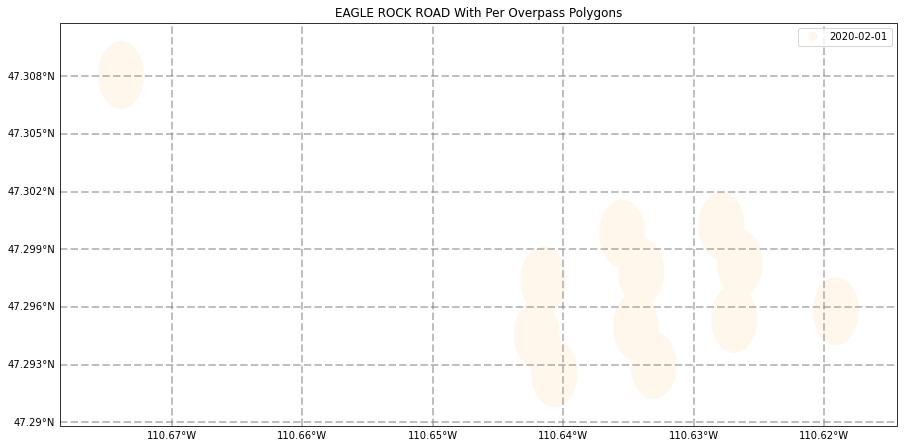

   Incident Number        Fire Name Current Day  Current Overpass   Lat Fire  \
0       11687777.0  EAGLE ROCK ROAD  2020-02-01             749.0  47.308056   
1       11687777.0  EAGLE ROCK ROAD  2020-02-01            2053.0  47.308056   

     Lon Fire  Number of NEW VIIRS points  NEW FRP  \
0 -110.673889                         0.0     0.00   
1 -110.673889                        11.0   677.38   

                                            geometry  daily_area  
0  POLYGON ((4788929.018 1450344.484, 4788922.763...   20.534371  
1  MULTIPOLYGON (((4792520.282 1447816.450, 47925...  204.162832  
LODE ROAD
<class 'str'>
0
['2020-02-02' '2020-02-03' '2020-02-04' '2020-02-05' '2020-02-06']
2020-02-02
2020-02-03
2020-02-04
2020-02-05
2020-02-06
0 seconds seconds elapsed
Valid Geometry
20.957835221099856 3680.0
1
['2020-02-02' '2020-02-03' '2020-02-04' '2020-02-05' '2020-02-06']
2020-02-02
2020-02-03
2020-02-04
2020-02-05
2020-02-06
1 seconds seconds elapsed
Valid Geometry
20.957835221099

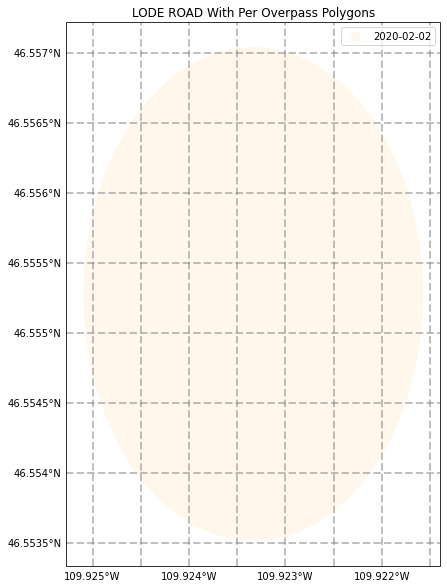

   Incident Number  Fire Name Current Day  Current Overpass   Lat Fire  \
0       11687821.0  LODE ROAD  2020-02-02             730.0  46.555278   

     Lon Fire  Number of NEW VIIRS points  NEW FRP  \
0 -109.923333                         0.0      0.0   

                                            geometry  daily_area  
0  POLYGON ((4820056.460 1352993.758, 4820050.394...   20.957835  
LOST LAKE
<class 'str'>
0
['2020-02-01' '2020-02-02' '2020-02-03']
2020-02-01
2020-02-02
2020-02-03
0 seconds seconds elapsed
Valid Geometry
20.344613139140982 1041.0
1
['2020-02-01' '2020-02-02' '2020-02-03']
2020-02-01
2020-02-02
2020-02-03
0 seconds seconds elapsed
Valid Geometry
Valid Geometry
40.69482107561013 1041.0
2
['2020-02-01' '2020-02-02' '2020-02-03']
2020-02-01
2020-02-02
2020-02-03
0 seconds seconds elapsed
Valid Geometry
Valid Geometry
Valid Geometry
81.37374061730065 1041.0
3
['2020-02-01' '2020-02-02' '2020-02-03']
2020-02-01
2020-02-02
2020-02-03
0 seconds seconds elapsed
Valid Geom

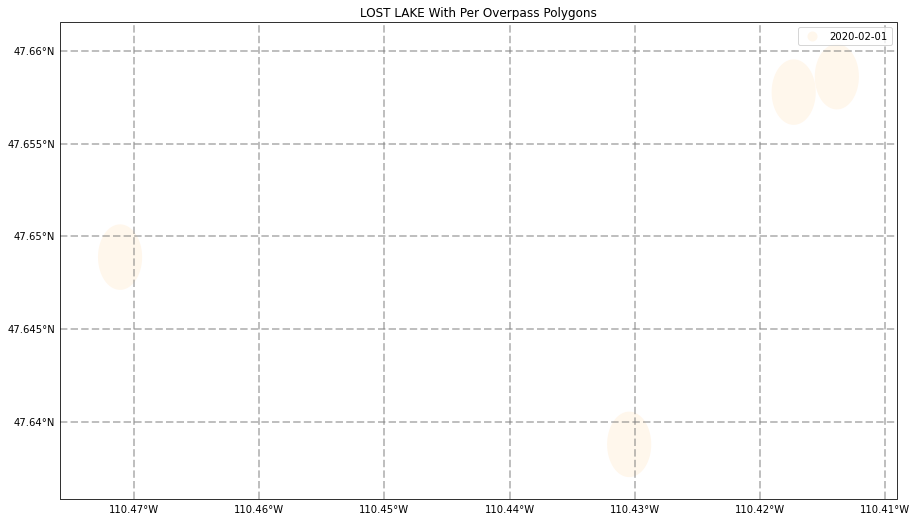

   Incident Number  Fire Name Current Day  Current Overpass   Lat Fire  \
0       11687977.0  LOST LAKE  2020-02-01             749.0  47.648889   
1       11687977.0  LOST LAKE  2020-02-01            1913.0  47.648889   
2       11687977.0  LOST LAKE  2020-02-01            2000.0  47.648889   

     Lon Fire  Number of NEW VIIRS points  NEW FRP  \
0 -110.471111                         0.0     0.00   
1 -110.471111                         1.0     4.13   
2 -110.471111                         2.0    19.50   

                                            geometry  daily_area  
0  POLYGON ((4814698.591 1482378.331, 4814692.407...   20.344613  
1  POLYGON ((4818876.960 1482158.613, 4818870.792...   20.339690  
2  MULTIPOLYGON (((4819153.039 1482172.853, 48191...   40.689437  
BENT FORT
<class 'str'>
0
['2020-04-11' '2020-04-12' '2020-04-13']
2020-04-11
2020-04-12
2020-04-13
0 seconds seconds elapsed
Valid Geometry
Valid Geometry
Valid Geometry
Valid Geometry
Valid Geometry
1417.107731240462

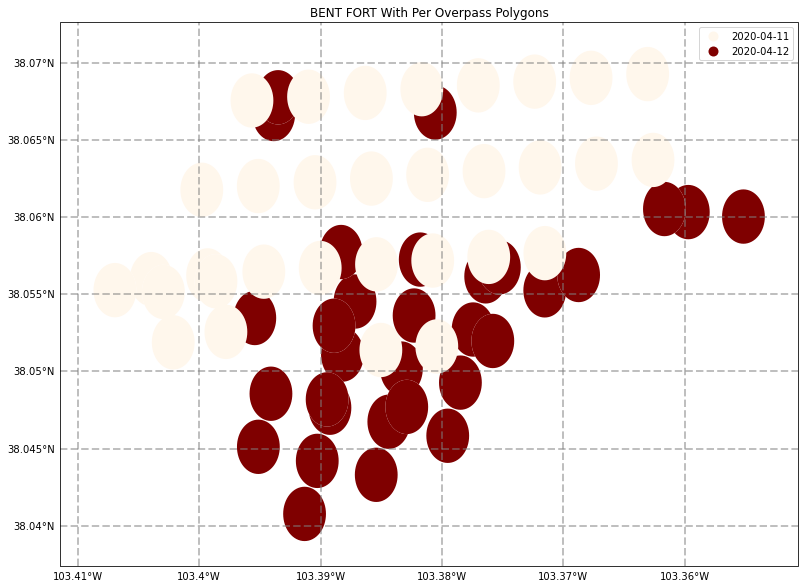

   Incident Number  Fire Name Current Day  Current Overpass   Lat Fire  \
0       11690273.0  BENT FORT  2020-04-11             737.0  38.055278   
1       11690273.0  BENT FORT  2020-04-11            1948.0  38.055278   
2       11690273.0  BENT FORT  2020-04-11            2038.0  38.055278   
3       11690273.0  BENT FORT  2020-04-12             806.0  38.055278   
4       11690273.0  BENT FORT  2020-04-12             858.0  38.055278   

     Lon Fire  Number of NEW VIIRS points  NEW FRP  \
0 -103.406944                         0.0     0.00   
1 -103.406944                         4.0   668.40   
2 -103.406944                        27.0  2624.61   
3 -103.406944                        13.0   327.20   
4 -103.406944                        18.0   251.70   

                                            geometry  daily_area  
0  POLYGON ((5135225.985 278115.500, 5135221.551 ...   26.232579  
1  MULTIPOLYGON (((5135793.401 277869.781, 513578...  104.392392  
2  MULTIPOLYGON (((5139527.71

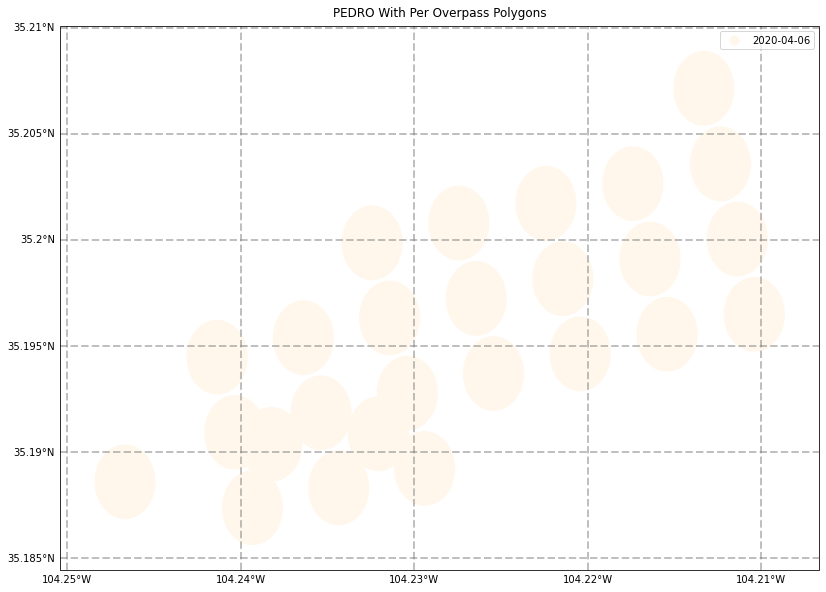

   Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
0       11692207.0     PEDRO  2020-04-06             818.0  35.188611   
1       11692207.0     PEDRO  2020-04-06            1942.0  35.188611   
2       11692207.0     PEDRO  2020-04-06            2031.0  35.188611   

     Lon Fire  Number of NEW VIIRS points  NEW FRP  \
0 -104.246667                         0.0     0.00   
1 -104.246667                        23.0   199.50   
2 -104.246667                         2.0    17.62   

                                            geometry  daily_area  
0  POLYGON ((4993037.547 -40375.633, 4993032.735 ...   28.256469  
1  MULTIPOLYGON (((4996712.980 -40137.974, 499670...  649.767525  
2  MULTIPOLYGON (((4994495.808 -40386.967, 499449...   41.021749  
K-25 AND RD 17
<class 'str'>
0
['2020-01-21']
2020-01-21
0 seconds seconds elapsed
Valid Geometry
26.080342634720708 1800.0
1
['2020-01-21']
2020-01-21
0 seconds seconds elapsed
Valid Geometry
26.080342634720708 1800.0
2
[

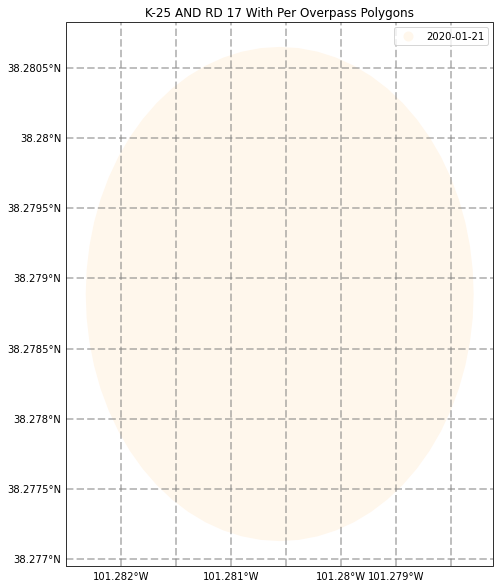

   Incident Number       Fire Name Current Day  Current Overpass   Lat Fire  \
0       11694721.0  K-25 AND RD 17  2020-01-21             756.0  38.278889   

     Lon Fire  Number of NEW VIIRS points  NEW FRP  \
0 -101.280556                         0.0      0.0   

                                            geometry  daily_area  
0  POLYGON ((5333716.815 271706.205, 5333713.054 ...   26.080343  
ROCK CREEK 0103 RN
<class 'str'>
0
['2020-04-30' '2020-05-01']
2020-04-30
2020-05-01
0 seconds seconds elapsed
Valid Geometry
21.526353900127702 1038.0
1
['2020-04-30' '2020-05-01']
2020-04-30
2020-05-01
0 seconds seconds elapsed
Valid Geometry
21.526353900127702 1038.0
2
['2020-04-30' '2020-05-01']
2020-04-30
2020-05-01
0 seconds seconds elapsed
Valid Geometry
21.526353900127702 1038.0
3
['2020-04-30' '2020-05-01']
2020-04-30
2020-05-01
0 seconds seconds elapsed
Valid Geometry
Valid Geometry
43.004237118922305 1038.0


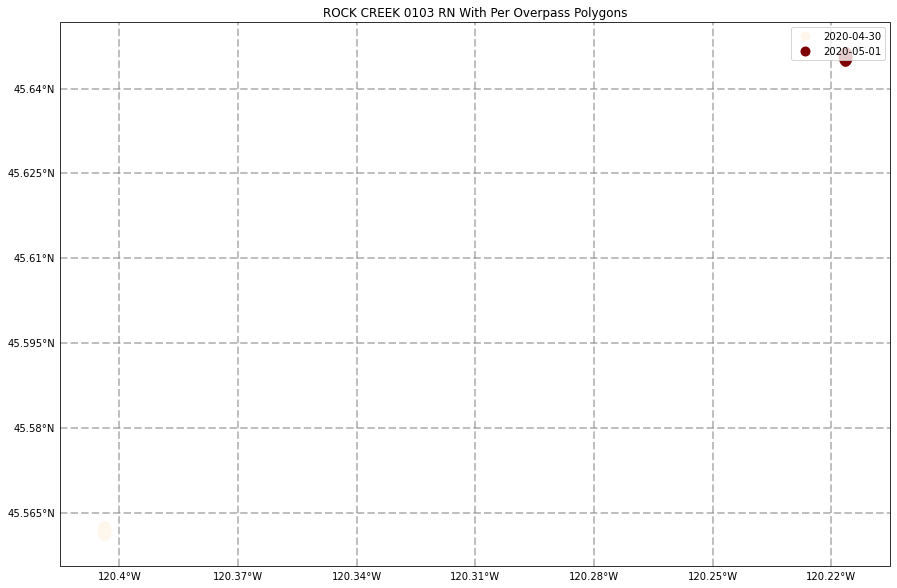

   Incident Number           Fire Name Current Day  Current Overpass  \
0       11702004.0  ROCK CREEK 0103 RN  2020-04-30             730.0   
1       11702004.0  ROCK CREEK 0103 RN  2020-05-01             940.0   

   Lat Fire  Lon Fire  Number of NEW VIIRS points  NEW FRP  \
0  45.56173 -120.4037                         0.0     0.00   
1  45.56173 -120.4037                         1.0     0.72   

                                            geometry  daily_area  
0  POLYGON ((4014384.042 1542658.173, 4014374.983...   21.526354  
1  POLYGON ((4031844.650 1544775.342, 4031835.645...   21.477883  
EAST DESERT
<class 'str'>
0
['2020-05-17' '2020-05-18' '2020-05-19' '2020-05-20' '2020-05-21'
 '2020-05-22']
2020-05-17
2020-05-18
2020-05-19
2020-05-20
2020-05-21
2020-05-22
0 seconds seconds elapsed
Valid Geometry
Valid Geometry
133.39901189362897 1492.0
1
['2020-05-17' '2020-05-18' '2020-05-19' '2020-05-20' '2020-05-21'
 '2020-05-22']
2020-05-17
2020-05-18
2020-05-19
2020-05-20
2020-05-21


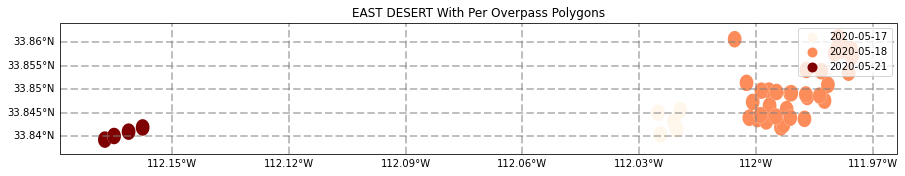

   Incident Number    Fire Name Current Day  Current Overpass  Lat Fire  \
0       11702184.0  EAST DESERT  2020-05-17             758.0  33.84136   
1       11702184.0  EAST DESERT  2020-05-17            2102.0  33.84136   
2       11702184.0  EAST DESERT  2020-05-18             830.0  33.84136   
3       11702184.0  EAST DESERT  2020-05-18             925.0  33.84136   
4       11702184.0  EAST DESERT  2020-05-18            1012.0  33.84136   
5       11702184.0  EAST DESERT  2020-05-21            1947.0  33.84136   
6       11702184.0  EAST DESERT  2020-05-21            2128.0  33.84136   

   Lon Fire  Number of NEW VIIRS points  NEW FRP  \
0 -112.0204                         0.0     0.00   
1 -112.0204                         4.0    52.62   
2 -112.0204                        14.0    37.60   
3 -112.0204                        14.0    25.41   
4 -112.0204                         6.0     8.00   
5 -112.0204                         3.0    33.18   
6 -112.0204                        

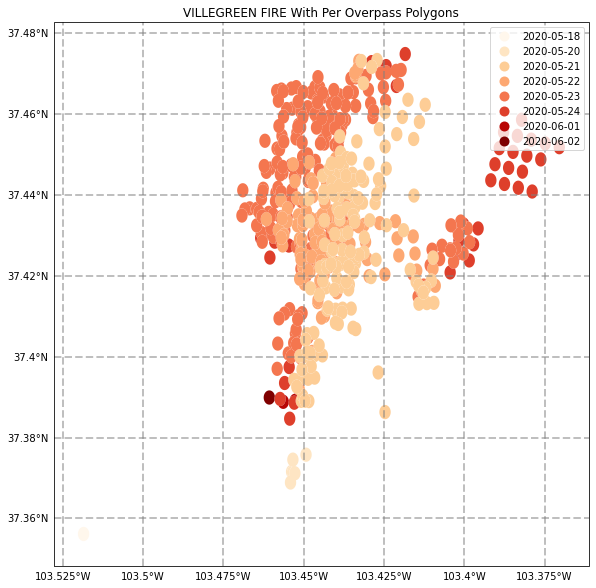

    Incident Number        Fire Name Current Day  Current Overpass   Lat Fire  \
0        11703898.0  VILLEGREEN FIRE  2020-05-18             739.0  37.356167   
1        11703898.0  VILLEGREEN FIRE  2020-05-20             754.0  37.356167   
2        11703898.0  VILLEGREEN FIRE  2020-05-20             845.0  37.356167   
3        11703898.0  VILLEGREEN FIRE  2020-05-20            2006.0  37.356167   
4        11703898.0  VILLEGREEN FIRE  2020-05-21             827.0  37.356167   
5        11703898.0  VILLEGREEN FIRE  2020-05-21             918.0  37.356167   
6        11703898.0  VILLEGREEN FIRE  2020-05-21            1854.0  37.356167   
7        11703898.0  VILLEGREEN FIRE  2020-05-21            1948.0  37.356167   
8        11703898.0  VILLEGREEN FIRE  2020-05-21            2036.0  37.356167   
9        11703898.0  VILLEGREEN FIRE  2020-05-22             808.0  37.356167   
10       11703898.0  VILLEGREEN FIRE  2020-05-22             854.0  37.356167   
11       11703898.0  VILLEGR

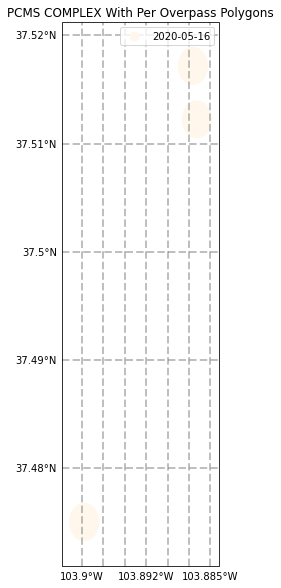

   Incident Number     Fire Name Current Day  Current Overpass  Lat Fire  \
0       11705534.0  PCMS COMPLEX  2020-05-16             817.0    37.475   
1       11705534.0  PCMS COMPLEX  2020-05-16            2030.0    37.475   

     Lon Fire  Number of NEW VIIRS points  NEW FRP  \
0 -103.899722                         0.0      0.0   
1 -103.899722                         2.0     25.4   

                                            geometry  daily_area  
0  POLYGON ((5077457.981 219539.413, 5077453.372 ...   26.630711  
1  MULTIPOLYGON (((5079558.906 224193.145, 507955...   53.206795  
BASIN
<class 'str'>
0
['2020-05-10' '2020-05-11' '2020-05-12' '2020-05-13' '2020-05-14'
 '2020-05-15' '2020-05-16' '2020-05-17' '2020-05-18' '2020-05-19'
 '2020-05-20']
2020-05-10
2020-05-11
2020-05-12
2020-05-13
2020-05-14
2020-05-15
2020-05-16
2020-05-17
2020-05-18
2020-05-19
2020-05-20
0 seconds seconds elapsed
Valid Geometry
Valid Geometry
310.9462842538033 38628.0
1
['2020-05-10' '2020-05-11' '2020-

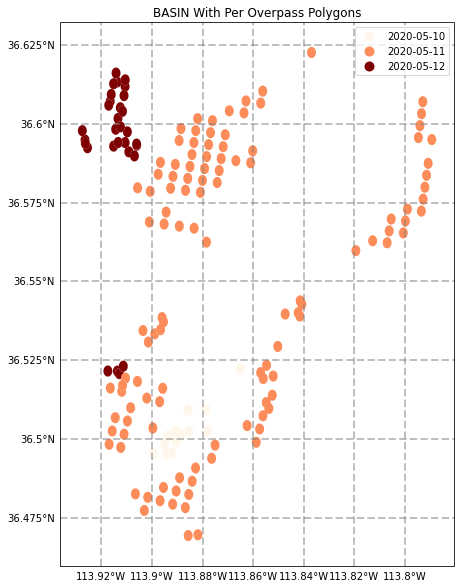

    Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
0        11705882.0     BASIN  2020-05-10             736.0  36.522222   
1        11705882.0     BASIN  2020-05-10            2042.0  36.522222   
2        11705882.0     BASIN  2020-05-10            2135.0  36.522222   
3        11705882.0     BASIN  2020-05-11             906.0  36.522222   
4        11705882.0     BASIN  2020-05-11             955.0  36.522222   
5        11705882.0     BASIN  2020-05-11            2024.0  36.522222   
6        11705882.0     BASIN  2020-05-11            2116.0  36.522222   
7        11705882.0     BASIN  2020-05-12             842.0  36.522222   
8        11705882.0     BASIN  2020-05-12             936.0  36.522222   
9        11705882.0     BASIN  2020-05-12            1024.0  36.522222   
10       11705882.0     BASIN  2020-05-12            2006.0  36.522222   
11       11705882.0     BASIN  2020-05-12            2057.0  36.522222   

    Lon Fire  Number of NEW VIIRS poi

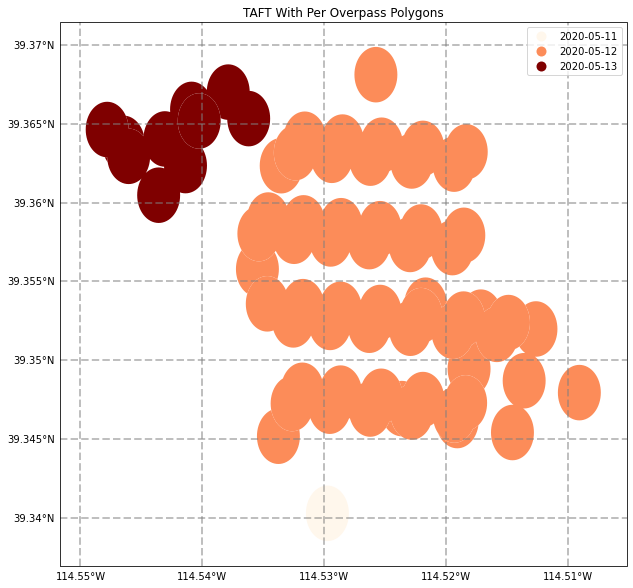

   Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
0       11706093.0      TAFT  2020-05-11             811.0  39.340278   
1       11706093.0      TAFT  2020-05-12             842.0  39.340278   
2       11706093.0      TAFT  2020-05-12             936.0  39.340278   
3       11706093.0      TAFT  2020-05-13             824.0  39.340278   
4       11706093.0      TAFT  2020-05-13             917.0  39.340278   
5       11706093.0      TAFT  2020-05-13            1006.0  39.340278   

     Lon Fire  Number of NEW VIIRS points  NEW FRP  \
0 -114.529722                         0.0     0.00   
1 -114.529722                        46.0   108.30   
2 -114.529722                        12.0    17.04   
3 -114.529722                         1.0     2.30   
4 -114.529722                         8.0    12.52   
5 -114.529722                         1.0     2.20   

                                            geometry  daily_area  
0  POLYGON ((4193895.708 692674.982, 41938

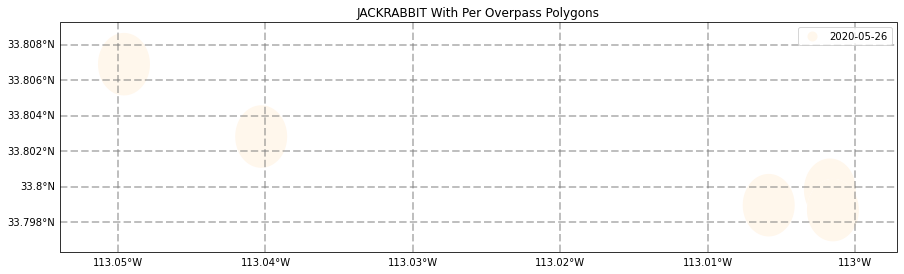

   Incident Number   Fire Name Current Day  Current Overpass  Lat Fire  \
0       11706760.0  JACKRABBIT  2020-05-26             736.0   33.8069   
1       11706760.0  JACKRABBIT  2020-05-26             834.0   33.8069   
2       11706760.0  JACKRABBIT  2020-05-26             924.0   33.8069   

   Lon Fire  Number of NEW VIIRS points  NEW FRP  \
0 -113.0496                         0.0     0.00   
1 -113.0496                         2.0     2.35   
2 -113.0496                         2.0     2.00   

                                            geometry  daily_area  
0  POLYGON ((4105556.525 27863.923, 4105548.900 2...   29.285013  
1  MULTIPOLYGON (((4109812.860 25343.033, 4109805...   58.582284  
2  MULTIPOLYGON (((4109838.523 25480.730, 4109830...   41.402138  
MOORE
<class 'str'>
0
['2020-05-02' '2020-05-03' '2020-05-04' '2020-05-05']
2020-05-02
2020-05-03
2020-05-04
2020-05-05
0 seconds seconds elapsed
Valid Geometry
Valid Geometry
Valid Geometry
Valid Geometry
Valid Geometry
Valid

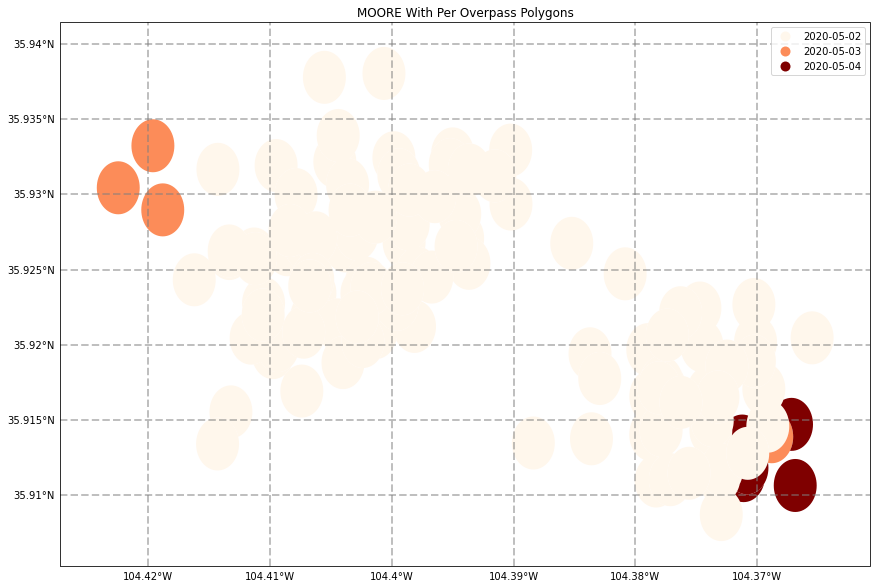

    Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
0        11707815.0     MOORE  2020-05-02             739.0  35.924722   
1        11707815.0     MOORE  2020-05-02             743.0  35.924722   
2        11707815.0     MOORE  2020-05-02             830.0  35.924722   
3        11707815.0     MOORE  2020-05-02             924.0  35.924722   
4        11707815.0     MOORE  2020-05-02            1904.0  35.924722   
5        11707815.0     MOORE  2020-05-02            1954.0  35.924722   
6        11707815.0     MOORE  2020-05-02            2044.0  35.924722   
7        11707815.0     MOORE  2020-05-03            2025.0  35.924722   
8        11707815.0     MOORE  2020-05-04             754.0  35.924722   
9        11707815.0     MOORE  2020-05-04             846.0  35.924722   
10       11707815.0     MOORE  2020-05-04             936.0  35.924722   

      Lon Fire  Number of NEW VIIRS points  NEW FRP  \
0  -104.380833                         0.0     0.00   
1

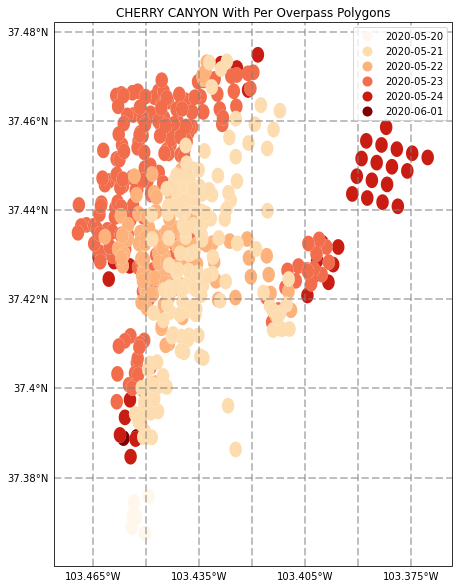

    Incident Number      Fire Name Current Day  Current Overpass  Lat Fire  \
0        11707842.0  CHERRY CANYON  2020-05-20             754.0   37.3675   
1        11707842.0  CHERRY CANYON  2020-05-20             845.0   37.3675   
2        11707842.0  CHERRY CANYON  2020-05-20            2006.0   37.3675   
3        11707842.0  CHERRY CANYON  2020-05-21             827.0   37.3675   
4        11707842.0  CHERRY CANYON  2020-05-21             918.0   37.3675   
5        11707842.0  CHERRY CANYON  2020-05-21            1854.0   37.3675   
6        11707842.0  CHERRY CANYON  2020-05-21            1948.0   37.3675   
7        11707842.0  CHERRY CANYON  2020-05-21            2036.0   37.3675   
8        11707842.0  CHERRY CANYON  2020-05-22             808.0   37.3675   
9        11707842.0  CHERRY CANYON  2020-05-22             854.0   37.3675   
10       11707842.0  CHERRY CANYON  2020-05-22            1929.0   37.3675   
11       11707842.0  CHERRY CANYON  2020-05-22            2018.0

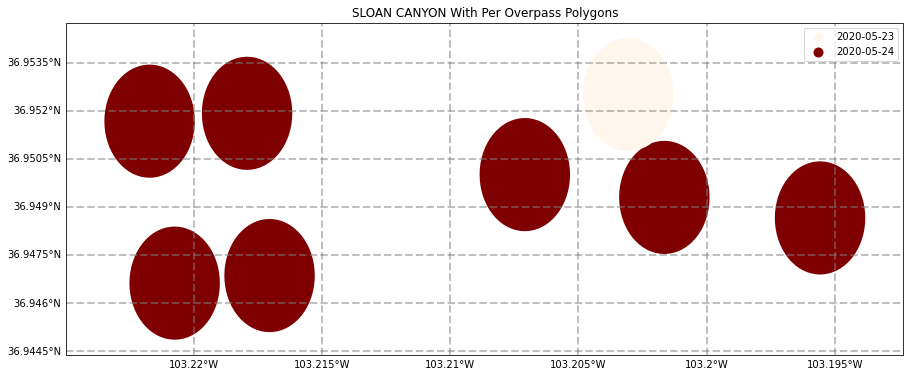

   Incident Number     Fire Name Current Day  Current Overpass  Lat Fire  \
0       11708995.0  SLOAN CANYON  2020-05-23             746.0   36.9525   
1       11708995.0  SLOAN CANYON  2020-05-24             818.0   36.9525   
2       11708995.0  SLOAN CANYON  2020-05-24            2032.0   36.9525   

     Lon Fire  Number of NEW VIIRS points  NEW FRP  \
0 -103.203056                         0.0     0.00   
1 -103.203056                         3.0     5.00   
2 -103.203056                         4.0    24.66   

                                            geometry  daily_area  
0  POLYGON ((5130822.073 146937.526, 5130817.661 ...   26.994272  
1  MULTIPOLYGON (((5131439.387 146365.355, 513143...   80.966171  
2  MULTIPOLYGON (((5129422.862 147120.072, 512941...  107.986130  
WOOD SPRINGS 2
<class 'str'>
0
['2020-06-27' '2020-06-28' '2020-06-29' '2020-06-30' '2020-07-01'
 '2020-07-02' '2020-07-03' '2020-07-04' '2020-07-05' '2020-07-06'
 '2020-07-07' '2020-07-08' '2020-07-09' '2020-0

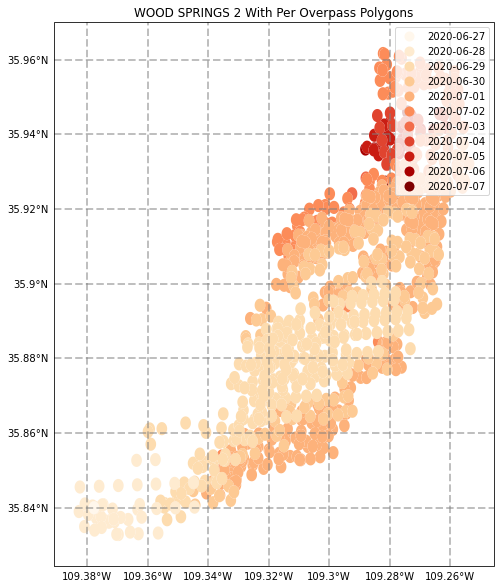

    Incident Number       Fire Name Current Day  Current Overpass  Lat Fire  \
0        11710471.0  WOOD SPRINGS 2  2020-06-27             736.0     35.84   
1        11710471.0  WOOD SPRINGS 2  2020-06-28             812.0     35.84   
2        11710471.0  WOOD SPRINGS 2  2020-06-28             906.0     35.84   
3        11710471.0  WOOD SPRINGS 2  2020-06-28             954.0     35.84   
4        11710471.0  WOOD SPRINGS 2  2020-06-28            1930.0     35.84   
5        11710471.0  WOOD SPRINGS 2  2020-06-28            2024.0     35.84   
6        11710471.0  WOOD SPRINGS 2  2020-06-28            2112.0     35.84   
7        11710471.0  WOOD SPRINGS 2  2020-06-29             842.0     35.84   
8        11710471.0  WOOD SPRINGS 2  2020-06-29             936.0     35.84   
9        11710471.0  WOOD SPRINGS 2  2020-06-29            1912.0     35.84   
10       11710471.0  WOOD SPRINGS 2  2020-06-29            2006.0     35.84   
11       11710471.0  WOOD SPRINGS 2  2020-06-29     

Valid Geometry
25.56922933197135 1094.0


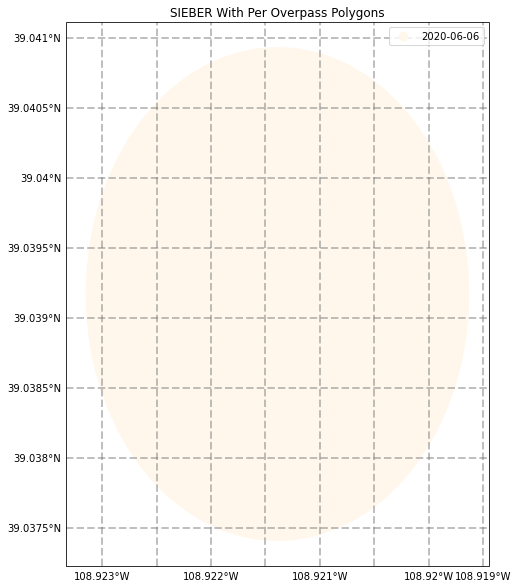

   Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
0       11710986.0    SIEBER  2020-06-06             730.0  39.039167   

     Lon Fire  Number of NEW VIIRS points  NEW FRP  \
0 -108.921389                         0.0      0.0   

                                            geometry  daily_area  
0  POLYGON ((4667070.916 503118.533, 4667064.830 ...   25.569229  
ELBERTA
<class 'str'>
0
['2020-06-06' '2020-06-07']
2020-06-06
2020-06-07
0 seconds seconds elapsed
Valid Geometry
24.98910485628245 1977.0
1
['2020-06-06' '2020-06-07']
2020-06-06
2020-06-07
0 seconds seconds elapsed
Valid Geometry
Valid Geometry
74.96158986466912 1977.0
2
['2020-06-06' '2020-06-07']
2020-06-06
2020-06-07
0 seconds seconds elapsed
Valid Geometry
Valid Geometry
74.96158986466912 1977.0
3
['2020-06-06' '2020-06-07']
2020-06-06
2020-06-07
0 seconds seconds elapsed
Valid Geometry
Valid Geometry
74.96158986466912 1977.0


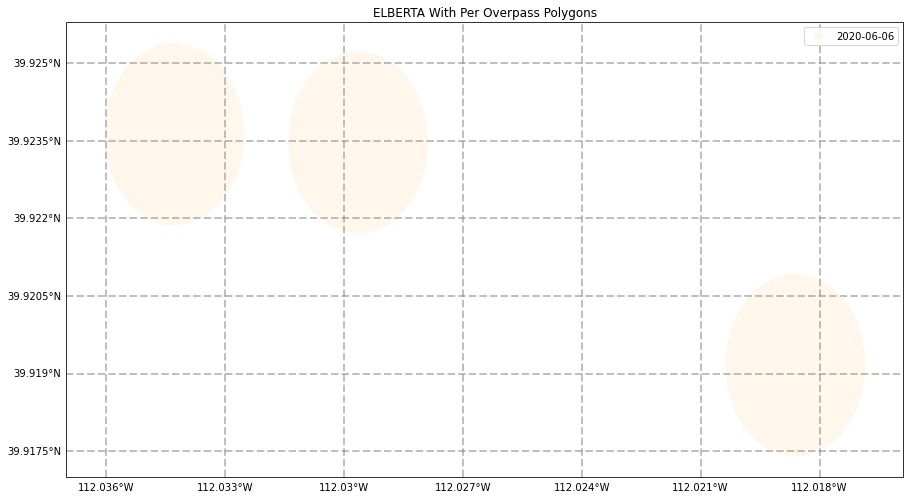

   Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
0       11711085.0   ELBERTA  2020-06-06             730.0  39.919167   
1       11711085.0   ELBERTA  2020-06-06             824.0  39.919167   

     Lon Fire  Number of NEW VIIRS points  NEW FRP  \
0 -112.018611                         0.0     0.00   
1 -112.018611                         2.0     8.12   

                                            geometry  daily_area  
0  POLYGON ((4429180.740 681647.429, 4429173.770 ...   24.989105  
1  MULTIPOLYGON (((4428399.856 682429.137, 442839...   49.972485  
BLUE RIVER
<class 'str'>
0
['2020-06-06' '2020-06-07' '2020-06-08' '2020-06-09' '2020-06-10'
 '2020-06-11' '2020-06-12' '2020-06-13' '2020-06-14' '2020-06-15'
 '2020-06-16' '2020-06-17' '2020-06-18' '2020-06-19' '2020-06-20'
 '2020-06-21' '2020-06-22' '2020-06-23' '2020-06-24' '2020-06-25'
 '2020-06-26']
2020-06-06
2020-06-07
2020-06-08
2020-06-09
2020-06-10
2020-06-11
2020-06-12
2020-06-13
2020-06-14
2020-06-15


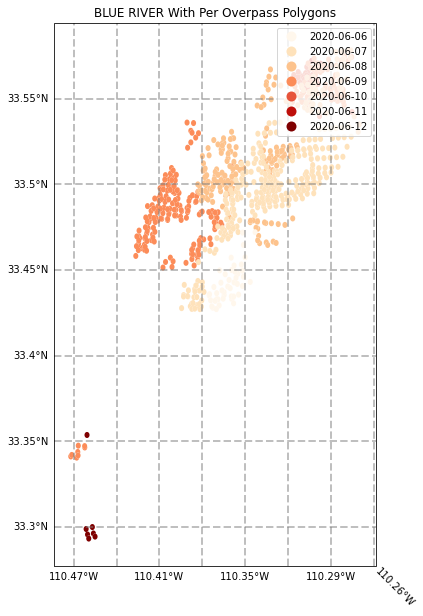

    Incident Number   Fire Name Current Day  Current Overpass   Lat Fire  \
0        11711119.0  BLUE RIVER  2020-06-06             730.0  33.434444   
1        11711119.0  BLUE RIVER  2020-06-06            1942.0  33.434444   
2        11711119.0  BLUE RIVER  2020-06-06            2036.0  33.434444   
3        11711119.0  BLUE RIVER  2020-06-06            2124.0  33.434444   
4        11711119.0  BLUE RIVER  2020-06-07             806.0  33.434444   
5        11711119.0  BLUE RIVER  2020-06-07             900.0  33.434444   
6        11711119.0  BLUE RIVER  2020-06-07             948.0  33.434444   
7        11711119.0  BLUE RIVER  2020-06-07            1924.0  33.434444   
8        11711119.0  BLUE RIVER  2020-06-07            2018.0  33.434444   
9        11711119.0  BLUE RIVER  2020-06-07            2106.0  33.434444   
10       11711119.0  BLUE RIVER  2020-06-08             836.0  33.434444   
11       11711119.0  BLUE RIVER  2020-06-08             930.0  33.434444   
12       117

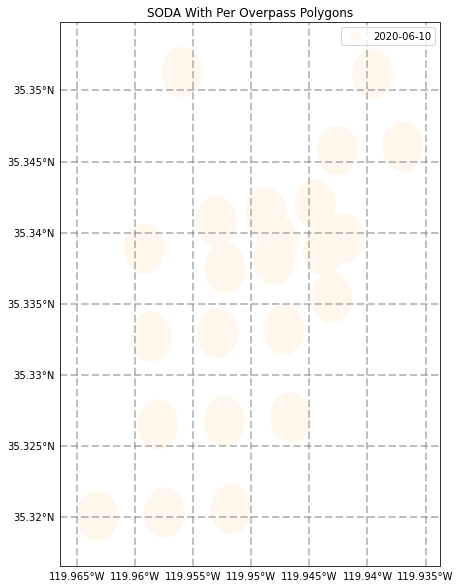

   Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
0       11711537.0      SODA  2020-06-10             754.0  35.351296   
1       11711537.0      SODA  2020-06-10            2100.0  35.351296   
2       11711537.0      SODA  2020-06-10            2148.0  35.351296   

     Lon Fire  Number of NEW VIIRS points  NEW FRP  \
0 -119.956015                         0.0      0.0   
1 -119.956015                         7.0    584.7   
2 -119.956015                        15.0    415.9   

                                            geometry  daily_area  
0  POLYGON ((3540913.722 458081.947, 3540904.153 ...   28.137767  
1  MULTIPOLYGON (((3541199.073 456491.546, 354119...  195.940259  
2  MULTIPOLYGON (((3542362.404 457380.195, 354235...  391.172672  
TEA KETTLE
<class 'str'>
0
['2020-06-06' '2020-06-07']
2020-06-06
2020-06-07
0 seconds seconds elapsed
Valid Geometry
23.06081452054371 1152.93
1
['2020-06-06' '2020-06-07']
2020-06-06
2020-06-07
0 seconds seconds elapsed


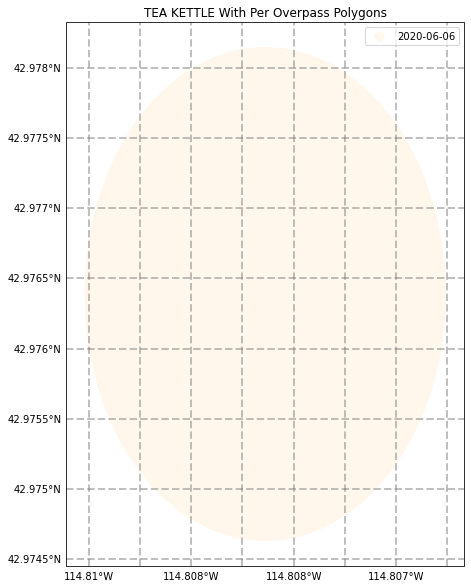

   Incident Number   Fire Name Current Day  Current Overpass   Lat Fire  \
0       11711845.0  TEA KETTLE  2020-06-06             730.0  42.976389   

     Lon Fire  Number of NEW VIIRS points  NEW FRP  \
0 -114.807778                         0.0      0.0   

                                            geometry  daily_area  
0  POLYGON ((4318270.342 1093709.530, 4318262.713...   23.060815  
CANAL
<class 'str'>
0
['2020-06-26' '2020-06-27' '2020-06-28' '2020-06-29' '2020-06-30'
 '2020-07-01' '2020-07-02' '2020-07-03' '2020-07-04' '2020-07-05'
 '2020-07-06' '2020-07-07' '2020-07-08' '2020-07-09' '2020-07-10'
 '2020-07-11' '2020-07-12' '2020-07-13' '2020-07-14']
2020-06-26
2020-06-27
2020-06-28
2020-06-29
2020-06-30
2020-07-01
2020-07-02
2020-07-03
2020-07-04
2020-07-05
2020-07-06
2020-07-07
2020-07-08
2020-07-09
2020-07-10
2020-07-11
2020-07-12
2020-07-13
2020-07-14
0 seconds seconds elapsed
Valid Geometry
Valid Geometry
50.62153644647756 78065.0
1
['2020-06-26' '2020-06-27' '2020-06-28'

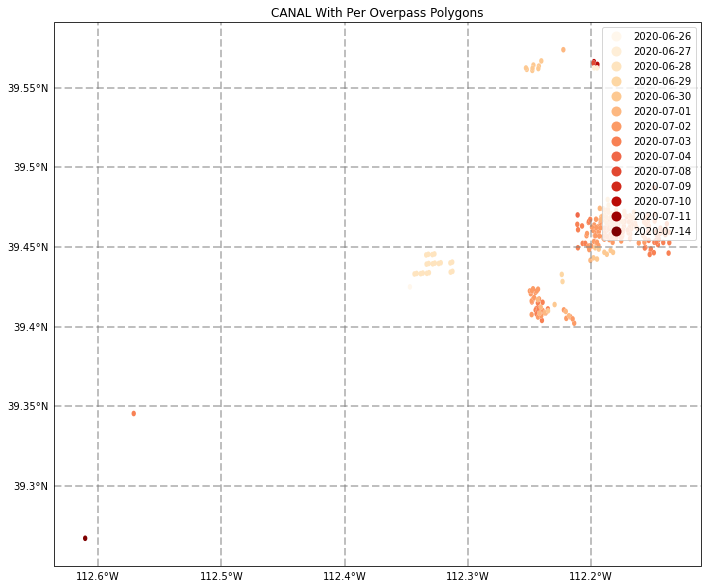

    Incident Number Fire Name Current Day  Current Overpass  Lat Fire  \
0        11711903.0     CANAL  2020-06-26             754.0    39.425   
1        11711903.0     CANAL  2020-06-27             918.0    39.425   
2        11711903.0     CANAL  2020-06-27            1012.0    39.425   
3        11711903.0     CANAL  2020-06-28            2112.0    39.425   
4        11711903.0     CANAL  2020-06-29            2054.0    39.425   
5        11711903.0     CANAL  2020-06-30             824.0    39.425   
6        11711903.0     CANAL  2020-06-30             912.0    39.425   
7        11711903.0     CANAL  2020-06-30            1006.0    39.425   
8        11711903.0     CANAL  2020-06-30            1948.0    39.425   
9        11711903.0     CANAL  2020-06-30            2036.0    39.425   
10       11711903.0     CANAL  2020-06-30            2130.0    39.425   
11       11711903.0     CANAL  2020-07-01             854.0    39.425   
12       11711903.0     CANAL  2020-07-01          

2020-06-29
2020-06-30
2020-07-01
2020-07-02
2020-07-03
2020-07-04
2020-07-05
0 seconds seconds elapsed
Valid Geometry
Valid Geometry
Valid Geometry
Valid Geometry
Valid Geometry
Valid Geometry
Valid Geometry
Valid Geometry
Valid Geometry
Valid Geometry
Valid Geometry
Valid Geometry
Valid Geometry
2618.5905460631598 4519.0


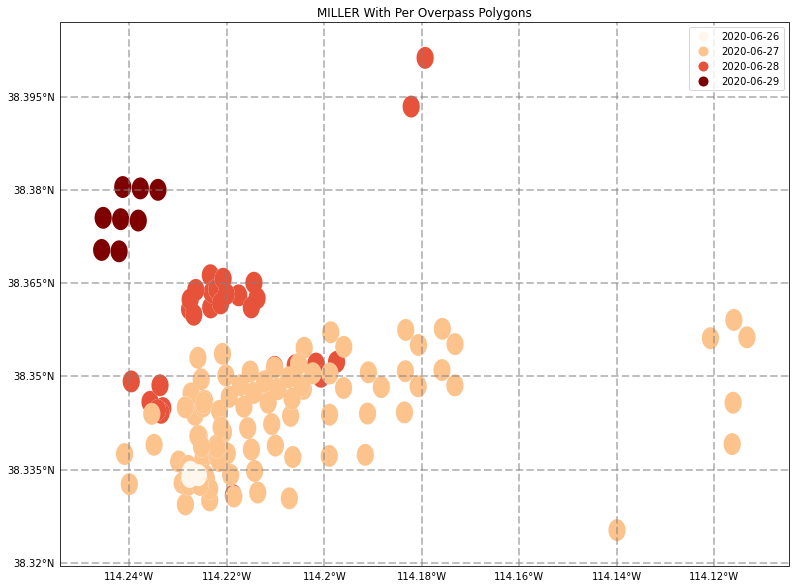

    Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
0        11712592.0    MILLER  2020-06-26             754.0  38.334667   
1        11712592.0    MILLER  2020-06-26            2012.0  38.334667   
2        11712592.0    MILLER  2020-06-27             830.0  38.334667   
3        11712592.0    MILLER  2020-06-27             924.0  38.334667   
4        11712592.0    MILLER  2020-06-27            1012.0  38.334667   
5        11712592.0    MILLER  2020-06-27            1954.0  38.334667   
6        11712592.0    MILLER  2020-06-27            2042.0  38.334667   
7        11712592.0    MILLER  2020-06-27            2130.0  38.334667   
8        11712592.0    MILLER  2020-06-28             900.0  38.334667   
9        11712592.0    MILLER  2020-06-28             954.0  38.334667   
10       11712592.0    MILLER  2020-06-28            2024.0  38.334667   
11       11712592.0    MILLER  2020-06-28            2112.0  38.334667   
12       11712592.0    MILLER  2020-06

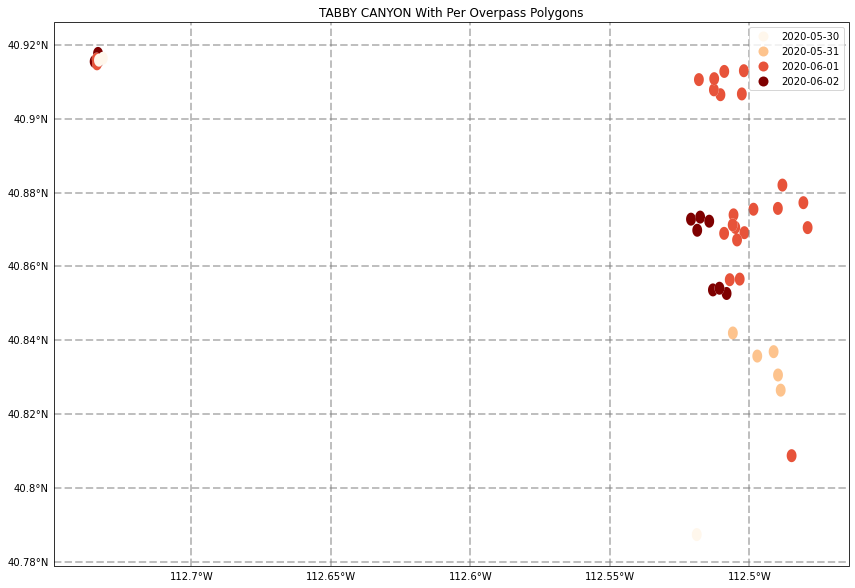

    Incident Number     Fire Name Current Day  Current Overpass  Lat Fire  \
0        11713776.0  TABBY CANYON  2020-05-30             800.0   40.7873   
1        11713776.0  TABBY CANYON  2020-05-30             857.0   40.7873   
2        11713776.0  TABBY CANYON  2020-05-30             948.0   40.7873   
3        11713776.0  TABBY CANYON  2020-05-31            2001.0   40.7873   
4        11713776.0  TABBY CANYON  2020-05-31            2048.0   40.7873   
5        11713776.0  TABBY CANYON  2020-06-01             906.0   40.7873   
6        11713776.0  TABBY CANYON  2020-06-01            1000.0   40.7873   
7        11713776.0  TABBY CANYON  2020-06-01            1942.0   40.7873   
8        11713776.0  TABBY CANYON  2020-06-01            2030.0   40.7873   
9        11713776.0  TABBY CANYON  2020-06-01            2118.0   40.7873   
10       11713776.0  TABBY CANYON  2020-06-02             848.0   40.7873   
11       11713776.0  TABBY CANYON  2020-06-02             936.0   40.7873   

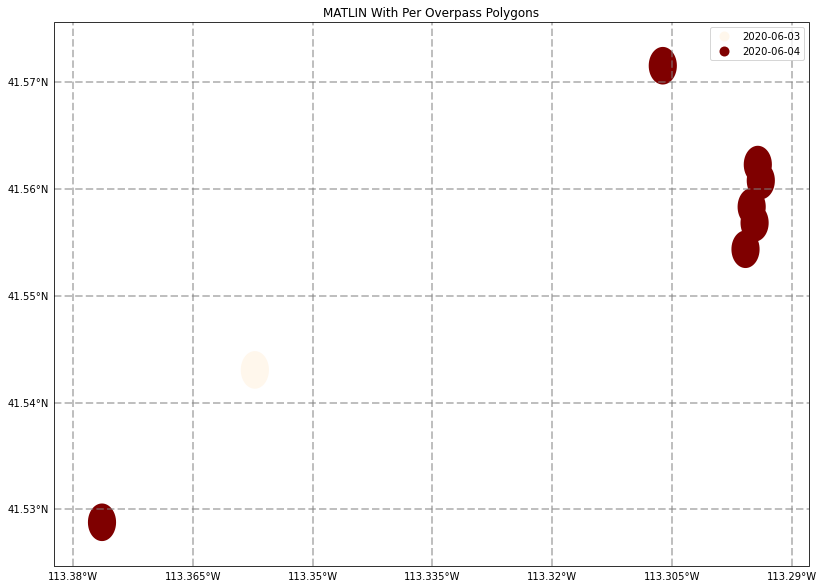

   Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
0       11714310.0    MATLIN  2020-06-03             736.0  41.543056   
1       11714310.0    MATLIN  2020-06-04             900.0  41.543056   

     Lon Fire  Number of NEW VIIRS points  NEW FRP  \
0 -113.357222                         0.0      0.0   
1 -113.357222                         7.0     12.4   

                                            geometry  daily_area  
0  POLYGON ((4378093.057 897126.241, 4378085.776 ...   23.948689  
1  MULTIPOLYGON (((4383451.162 896972.358, 438345...  139.473162  
BAR H
<class 'str'>
0
['2020-06-04' '2020-06-05']
2020-06-04
2020-06-05
0 seconds seconds elapsed
Valid Geometry
23.783575030340646 1352.0
1
['2020-06-04' '2020-06-05']
2020-06-04
2020-06-05
0 seconds seconds elapsed
Valid Geometry
23.783575030340646 1352.0
2
['2020-06-04' '2020-06-05']
2020-06-04
2020-06-05
0 seconds seconds elapsed
Valid Geometry
23.783575030340646 1352.0
3
['2020-06-04' '2020-06-05']
2020-06-0

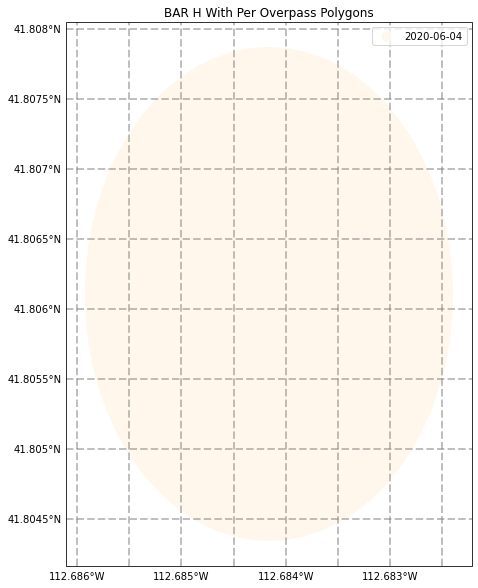

   Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
0       11714409.0     BAR H  2020-06-04             812.0  41.806111   

     Lon Fire  Number of NEW VIIRS points  NEW FRP  \
0 -112.684167                         0.0      0.0   

                                            geometry  daily_area  
0  POLYGON ((4442790.614 906770.958, 4442783.542 ...   23.783575  
IBAPAH
<class 'str'>
0
['2020-05-31' '2020-06-01']
2020-05-31
2020-06-01
0 seconds seconds elapsed
Valid Geometry
24.712583940791326 7153.9
1
['2020-05-31' '2020-06-01']
2020-05-31
2020-06-01
0 seconds seconds elapsed
Valid Geometry
24.712583940791326 7153.9
2
['2020-05-31' '2020-06-01']
2020-05-31
2020-06-01
0 seconds seconds elapsed
Valid Geometry
Valid Geometry
393.44603676640213 7153.9
3
['2020-05-31' '2020-06-01']
2020-05-31
2020-06-01
0 seconds seconds elapsed
Valid Geometry
Valid Geometry
393.44603676640213 7153.9


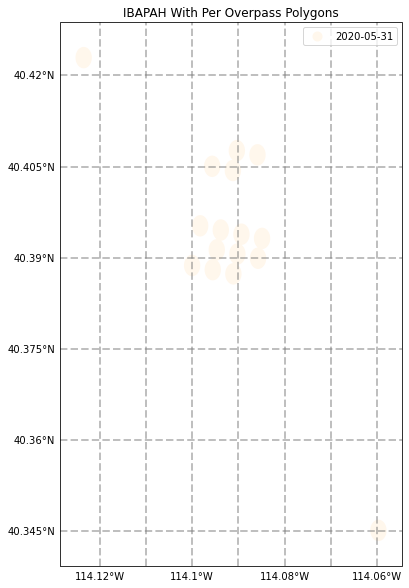

   Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
0       11714462.0    IBAPAH  2020-05-31             742.0  40.345083   
1       11714462.0    IBAPAH  2020-05-31             930.0  40.345083   

     Lon Fire  Number of NEW VIIRS points  NEW FRP  \
0 -114.059722                         0.0      0.0   
1 -114.059722                        15.0     44.2   

                                            geometry  daily_area  
0  POLYGON ((4273666.939 787643.493, 4273659.392 ...   24.712584  
1  MULTIPOLYGON (((4273940.486 795163.218, 427393...  368.733453  
BLUE WEST
<class 'str'>
0
['2020-06-12' '2020-06-13' '2020-06-14' '2020-06-15']
2020-06-12
2020-06-13
2020-06-14
2020-06-15
0 seconds seconds elapsed
Valid Geometry
27.892634410905107 1200.0
1
['2020-06-12' '2020-06-13' '2020-06-14' '2020-06-15']
2020-06-12
2020-06-13
2020-06-14
2020-06-15
0 seconds seconds elapsed
Valid Geometry
27.892634410905107 1200.0
2
['2020-06-12' '2020-06-13' '2020-06-14' '2020-06-15']
20

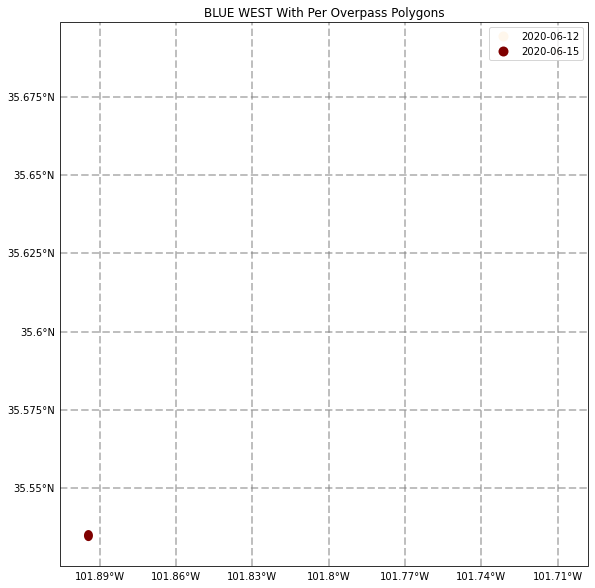

   Incident Number  Fire Name Current Day  Current Overpass   Lat Fire  \
0       11714572.0  BLUE WEST  2020-06-12             806.0  35.689183   
1       11714572.0  BLUE WEST  2020-06-15            1836.0  35.689183   

     Lon Fire  Number of NEW VIIRS points  NEW FRP  \
0 -101.709133                         0.0     0.00   
1 -101.709133                         1.0     4.46   

                                            geometry  daily_area  
0  POLYGON ((5247432.987 -24622.924, 5247429.000 ...   27.892634  
1  POLYGON ((5226765.190 -39988.762, 5226761.138 ...   28.004314  
BROWNS
<class 'str'>
0
['2020-05-31' '2020-06-01']
2020-05-31
2020-06-01
0 seconds seconds elapsed
Valid Geometry
23.14347842925747 2400.7
1
['2020-05-31' '2020-06-01']
2020-05-31
2020-06-01
0 seconds seconds elapsed
Valid Geometry
23.14347842925747 2400.7
2
['2020-05-31' '2020-06-01']
2020-05-31
2020-06-01
0 seconds seconds elapsed
Valid Geometry
23.14347842925747 2400.7
3
['2020-05-31' '2020-06-01']
2020-05-

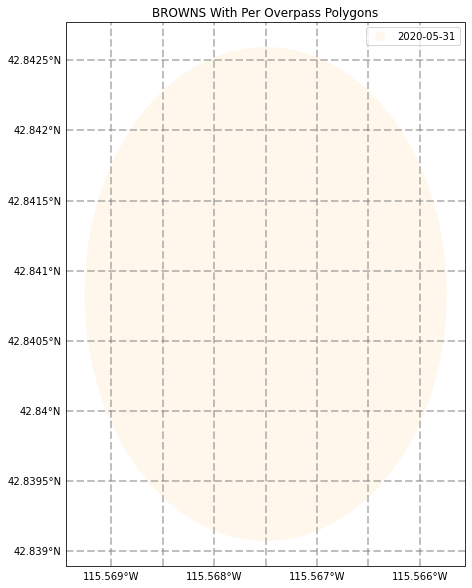

   Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
0       11714957.0    BROWNS  2020-05-31             742.0  42.840833   

   Lon Fire  Number of NEW VIIRS points  NEW FRP  \
0 -115.5675                         0.0      0.0   

                                            geometry  daily_area  
0  POLYGON ((4253175.077 1102120.543, 4253167.224...   23.143478  
SCORPION
<class 'str'>
0
['2020-05-31' '2020-06-01' '2020-06-02' '2020-06-03' '2020-06-04'
 '2020-06-05' '2020-06-06' '2020-06-07' '2020-06-08' '2020-06-09'
 '2020-06-10' '2020-06-11' '2020-06-12' '2020-06-13' '2020-06-14'
 '2020-06-15' '2020-06-16' '2020-06-17' '2020-06-18' '2020-06-19'
 '2020-06-20']
2020-05-31
2020-06-01
2020-06-02
2020-06-03
2020-06-04
2020-06-05
2020-06-06
2020-06-07
2020-06-08
2020-06-09
2020-06-10
2020-06-11
2020-06-12
2020-06-13
2020-06-14
2020-06-15
2020-06-16
2020-06-17
2020-06-18
2020-06-19
2020-06-20
0 seconds seconds elapsed
Valid Geometry
Valid Geometry
Valid Geometry
Valid Ge

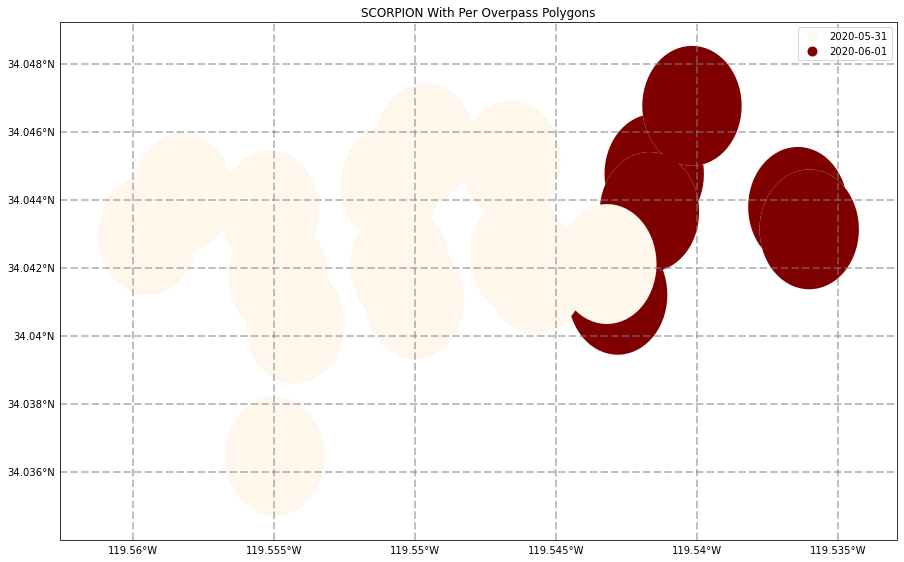

   Incident Number Fire Name Current Day  Current Overpass  Lat Fire  \
0       11715478.0  SCORPION  2020-05-31             742.0  34.04211   
1       11715478.0  SCORPION  2020-05-31            2048.0  34.04211   
2       11715478.0  SCORPION  2020-05-31            2140.0  34.04211   
3       11715478.0  SCORPION  2020-06-01             912.0  34.04211   
4       11715478.0  SCORPION  2020-06-01            1000.0  34.04211   

   Lon Fire  Number of NEW VIIRS points  NEW FRP  \
0 -119.5432                         0.0     0.00   
1 -119.5432                         9.0    76.00   
2 -119.5432                         4.0    59.74   
3 -119.5432                         3.0     7.30   
4 -119.5432                         3.0     7.71   

                                            geometry  daily_area  
0  POLYGON ((3511298.285 298561.632, 3511288.738 ...   29.107347  
1  MULTIPOLYGON (((3510602.077 299419.734, 351060...  231.115741  
2  MULTIPOLYGON (((3511027.962 298920.934, 351103... 

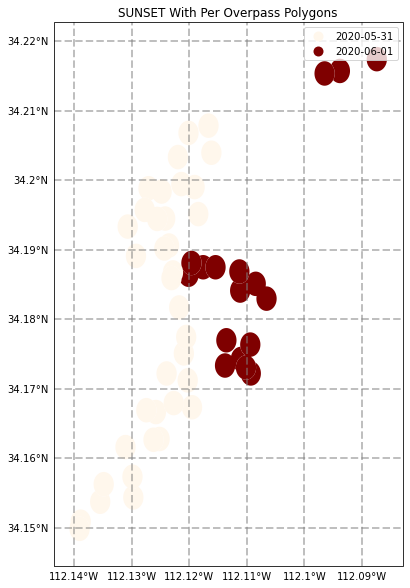

   Incident Number Fire Name Current Day  Current Overpass  Lat Fire  \
0       11715591.0    SUNSET  2020-05-31             742.0  34.14984   
1       11715591.0    SUNSET  2020-05-31            2000.0  34.14984   
2       11715591.0    SUNSET  2020-05-31            2048.0  34.14984   
3       11715591.0    SUNSET  2020-06-01             912.0  34.14984   
4       11715591.0    SUNSET  2020-06-01            1000.0  34.14984   

   Lon Fire  Number of NEW VIIRS points  NEW FRP  \
0 -112.1391                         0.0     0.00   
1 -112.1391                        16.0   308.56   
2 -112.1391                        19.0  1295.30   
3 -112.1391                         8.0    15.90   
4 -112.1391                         9.0    20.17   

                                            geometry  daily_area  
0  POLYGON ((4205398.272 37755.860, 4205390.947 3...   29.026331  
1  MULTIPOLYGON (((4208017.495 42494.328, 4208005...  440.941653  
2  MULTIPOLYGON (((4209716.250 43686.258, 4209708... 

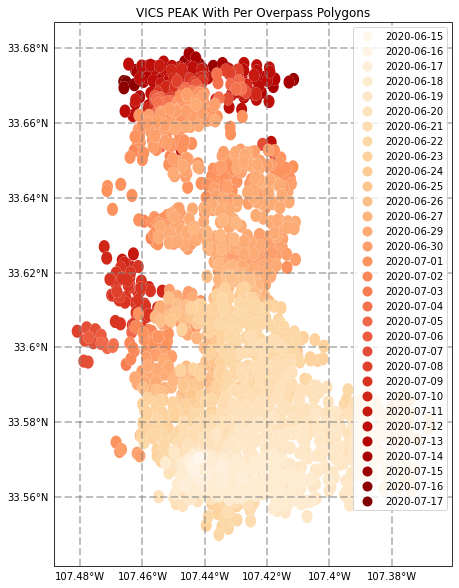

     Incident Number  Fire Name Current Day  Current Overpass  Lat Fire  \
0         11716626.0  VICS PEAK  2020-06-15             800.0   33.5703   
1         11716626.0  VICS PEAK  2020-06-16             836.0   33.5703   
2         11716626.0  VICS PEAK  2020-06-16            1906.0   33.5703   
3         11716626.0  VICS PEAK  2020-06-16            1954.0   33.5703   
4         11716626.0  VICS PEAK  2020-06-17            1936.0   33.5703   
..               ...        ...         ...               ...       ...   
103       11716626.0  VICS PEAK  2020-07-15             842.0   33.5703   
104       11716626.0  VICS PEAK  2020-07-16            1942.0   33.5703   
105       11716626.0  VICS PEAK  2020-07-16            2036.0   33.5703   
106       11716626.0  VICS PEAK  2020-07-17             854.0   33.5703   
107       11716626.0  VICS PEAK  2020-07-17            2018.0   33.5703   

     Lon Fire  Number of NEW VIIRS points  NEW FRP  \
0   -107.4418                         0.0    

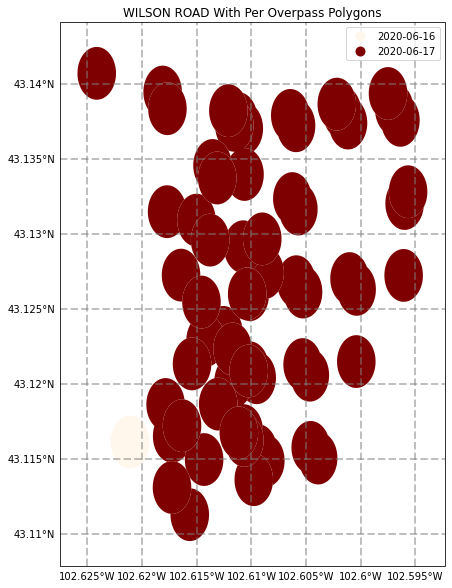

   Incident Number    Fire Name Current Day  Current Overpass   Lat Fire  \
0       11717396.0  WILSON ROAD  2020-06-16             742.0  43.116111   
1       11717396.0  WILSON ROAD  2020-06-17             818.0  43.116111   
2       11717396.0  WILSON ROAD  2020-06-17             906.0  43.116111   
3       11717396.0  WILSON ROAD  2020-06-17             954.0  43.116111   
4       11717396.0  WILSON ROAD  2020-06-17            1942.0  43.116111   
5       11717396.0  WILSON ROAD  2020-06-17            2030.0  43.116111   

     Lon Fire  Number of NEW VIIRS points  NEW FRP  \
0 -102.621111                         0.0     0.00   
1 -102.621111                         9.0    27.44   
2 -102.621111                        12.0    29.30   
3 -102.621111                         6.0    10.85   
4 -102.621111                        10.0   189.11   
5 -102.621111                        26.0   260.50   

                                            geometry  daily_area  
0  POLYGON ((5305506.

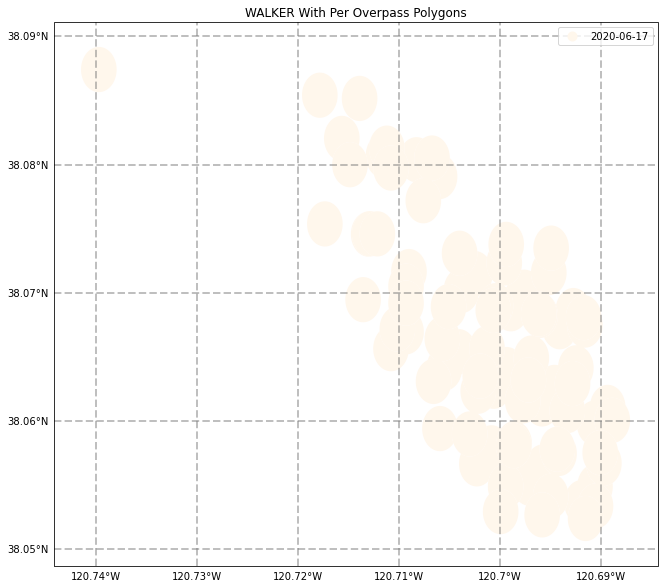

   Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
0       11717541.0    WALKER  2020-06-17             730.0  38.087413   
1       11717541.0    WALKER  2020-06-17             912.0  38.087413   
2       11717541.0    WALKER  2020-06-17            1000.0  38.087413   
3       11717541.0    WALKER  2020-06-17            1048.0  38.087413   
4       11717541.0    WALKER  2020-06-17            2030.0  38.087413   

     Lon Fire  Number of NEW VIIRS points  NEW FRP  \
0 -120.739745                         0.0     0.00   
1 -120.739745                        22.0    39.20   
2 -120.739745                        30.0    75.82   
3 -120.739745                        27.0   267.50   
4 -120.739745                         1.0     6.70   

                                            geometry  daily_area  
0  POLYGON ((3613786.766 782283.089, 3613777.169 ...   26.210382  
1  MULTIPOLYGON (((3616805.292 778994.342, 361679...  576.926272  
2  MULTIPOLYGON (((3616226.518 7780

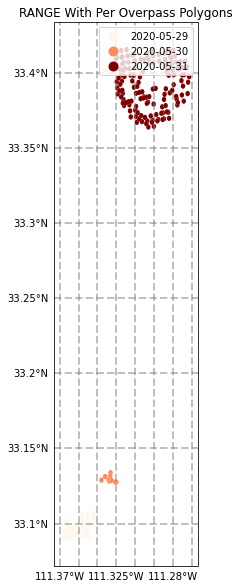

    Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
0        11717874.0     RANGE  2020-05-29             733.0  33.098333   
1        11717874.0     RANGE  2020-05-29            1948.0  33.098333   
2        11717874.0     RANGE  2020-05-29            2037.0  33.098333   
3        11717874.0     RANGE  2020-05-29            2124.0  33.098333   
4        11717874.0     RANGE  2020-05-30             806.0  33.098333   
5        11717874.0     RANGE  2020-05-30             900.0  33.098333   
6        11717874.0     RANGE  2020-05-30             948.0  33.098333   
7        11717874.0     RANGE  2020-05-31             841.0  33.098333   
8        11717874.0     RANGE  2020-05-31             930.0  33.098333   
9        11717874.0     RANGE  2020-05-31            1021.0  33.098333   
10       11717874.0     RANGE  2020-05-31            1959.0  33.098333   
11       11717874.0     RANGE  2020-05-31            2048.0  33.098333   

      Lon Fire  Number of NEW VIIRS p

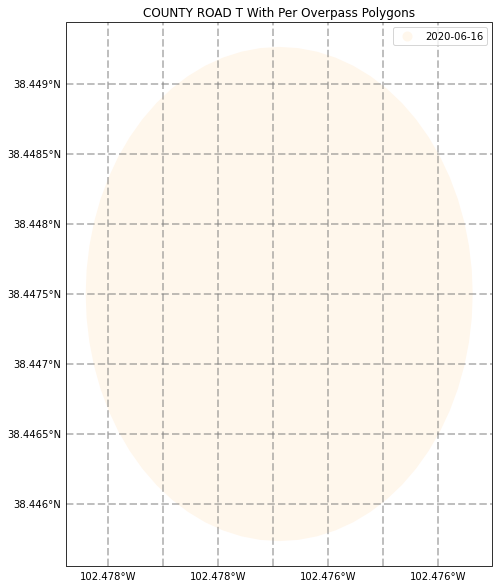

   Incident Number      Fire Name Current Day  Current Overpass  Lat Fire  \
0       11718294.0  COUNTY ROAD T  2020-06-16             742.0   38.4475   

     Lon Fire  Number of NEW VIIRS points  NEW FRP  \
0 -102.476944                         0.0      0.0   

                                            geometry  daily_area  
0  POLYGON ((5227845.602 308502.574, 5227841.472 ...   25.966217  
PROWERS
<class 'str'>
0
['2020-06-17']
2020-06-17
0 seconds seconds elapsed
Valid Geometry
Valid Geometry
79.44918141193389 1472.0
1
['2020-06-17']
2020-06-17
0 seconds seconds elapsed
Valid Geometry
Valid Geometry
158.86399867419553 1472.0
2
['2020-06-17']
2020-06-17
0 seconds seconds elapsed
Valid Geometry
Valid Geometry
158.86399867419553 1472.0
3
['2020-06-17']
2020-06-17
0 seconds seconds elapsed
Valid Geometry
Valid Geometry
158.86399867419553 1472.0


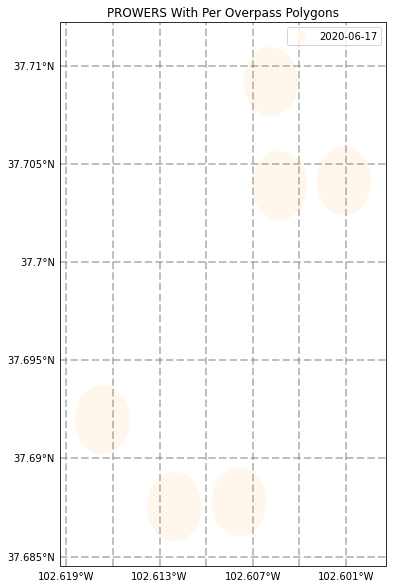

   Incident Number Fire Name Current Day  Current Overpass  Lat Fire  \
0       11718507.0   PROWERS  2020-06-17             730.0  37.69197   
1       11718507.0   PROWERS  2020-06-17            2030.0  37.69197   

   Lon Fire  Number of NEW VIIRS points  NEW FRP  \
0 -102.6167                         0.0      0.0   
1 -102.6167                         5.0     30.4   

                                            geometry  daily_area  
0  POLYGON ((5200250.489 223262.368, 5200246.288 ...   26.481089  
1  MULTIPOLYGON (((5201926.625 224430.922, 520192...  132.382909  
WIRE PASS
<class 'str'>
0
['2020-06-27' '2020-06-28' '2020-06-29' '2020-06-30' '2020-07-01'
 '2020-07-02' '2020-07-03']
2020-06-27
2020-06-28
2020-06-29
2020-06-30
2020-07-01
2020-07-02
2020-07-03
0 seconds seconds elapsed
Valid Geometry
Valid Geometry
Valid Geometry
Valid Geometry
Valid Geometry
Valid Geometry
Valid Geometry
800.9749715254071 1588.0
1
['2020-06-27' '2020-06-28' '2020-06-29' '2020-06-30' '2020-07-01'
 '20

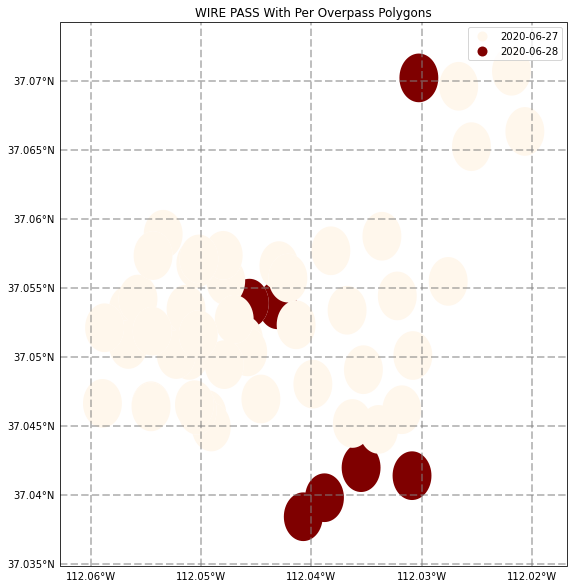

   Incident Number  Fire Name Current Day  Current Overpass  Lat Fire  \
0       11719259.0  WIRE PASS  2020-06-27             736.0  37.04655   
1       11719259.0  WIRE PASS  2020-06-27             830.0  37.04655   
2       11719259.0  WIRE PASS  2020-06-27             924.0  37.04655   
3       11719259.0  WIRE PASS  2020-06-27            1012.0  37.04655   
4       11719259.0  WIRE PASS  2020-06-27            1954.0  37.04655   
5       11719259.0  WIRE PASS  2020-06-28             812.0  37.04655   
6       11719259.0  WIRE PASS  2020-06-28             900.0  37.04655   

   Lon Fire  Number of NEW VIIRS points  NEW FRP  \
0 -112.0506                         0.0     0.00   
1 -112.0506                         8.0    29.11   
2 -112.0506                         7.0    79.10   
3 -112.0506                         8.0    60.95   
4 -112.0506                        22.0   941.62   
5 -112.0506                         3.0     8.94   
6 -112.0506                         4.0     4.80   

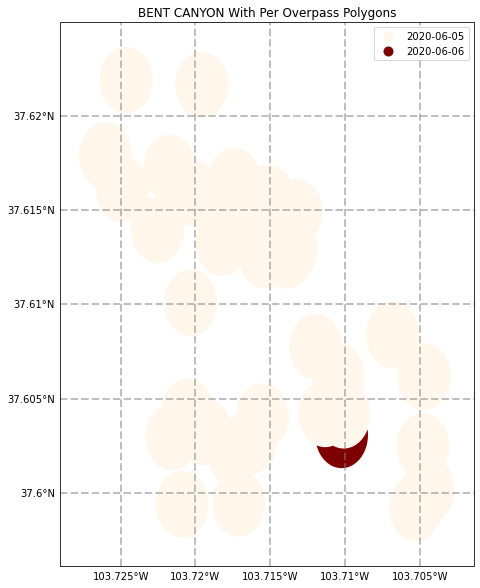

   Incident Number    Fire Name Current Day  Current Overpass  Lat Fire  \
0       11719463.0  BENT CANYON  2020-06-05             748.0  37.60249   
1       11719463.0  BENT CANYON  2020-06-05             754.0  37.60249   
2       11719463.0  BENT CANYON  2020-06-05             842.0  37.60249   
3       11719463.0  BENT CANYON  2020-06-05             936.0  37.60249   
4       11719463.0  BENT CANYON  2020-06-05            1912.0  37.60249   
5       11719463.0  BENT CANYON  2020-06-05            2006.0  37.60249   
6       11719463.0  BENT CANYON  2020-06-05            2054.0  37.60249   
7       11719463.0  BENT CANYON  2020-06-06             912.0  37.60249   

   Lon Fire  Number of NEW VIIRS points  NEW FRP  \
0 -103.7048                         0.0     0.00   
1 -103.7048                         8.0     9.40   
2 -103.7048                         9.0    12.58   
3 -103.7048                         4.0     6.80   
4 -103.7048                         3.0   176.40   
5 -103.7048 

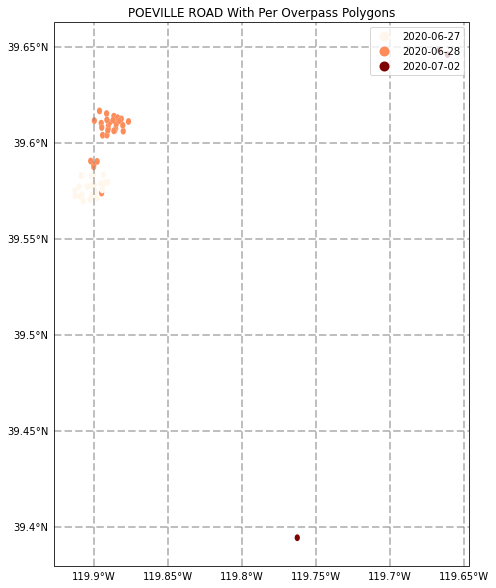

   Incident Number      Fire Name Current Day  Current Overpass   Lat Fire  \
0       11719716.0  POEVILLE ROAD  2020-06-27             736.0  39.575556   
1       11719716.0  POEVILLE ROAD  2020-06-27            2042.0  39.575556   
2       11719716.0  POEVILLE ROAD  2020-06-27            2136.0  39.575556   
3       11719716.0  POEVILLE ROAD  2020-06-28             900.0  39.575556   
4       11719716.0  POEVILLE ROAD  2020-06-28             954.0  39.575556   
5       11719716.0  POEVILLE ROAD  2020-06-28            1042.0  39.575556   
6       11719716.0  POEVILLE ROAD  2020-07-02             930.0  39.575556   
7       11719716.0  POEVILLE ROAD  2020-07-02            2000.0  39.575556   

   Lon Fire  Number of NEW VIIRS points  NEW FRP  \
0 -119.9125                         0.0     0.00   
1 -119.9125                        10.0   680.60   
2 -119.9125                        13.0  1213.81   
3 -119.9125                         7.0    82.60   
4 -119.9125                        10

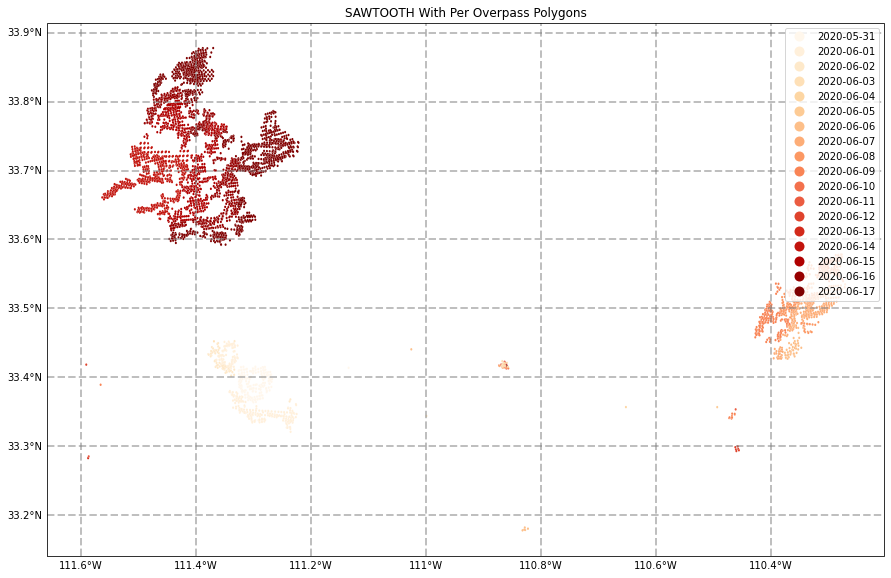

    Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
0        11721009.0  SAWTOOTH  2020-05-31             742.0  33.413889   
1        11721009.0  SAWTOOTH  2020-05-31             841.0  33.413889   
2        11721009.0  SAWTOOTH  2020-05-31             930.0  33.413889   
3        11721009.0  SAWTOOTH  2020-05-31            1021.0  33.413889   
4        11721009.0  SAWTOOTH  2020-05-31            1959.0  33.413889   
..              ...       ...         ...               ...        ...   
79       11721009.0  SAWTOOTH  2020-06-17             912.0  33.413889   
80       11721009.0  SAWTOOTH  2020-06-17            1000.0  33.413889   
81       11721009.0  SAWTOOTH  2020-06-17            1936.0  33.413889   
82       11721009.0  SAWTOOTH  2020-06-17            2030.0  33.413889   
83       11721009.0  SAWTOOTH  2020-06-17            2118.0  33.413889   

      Lon Fire  Number of NEW VIIRS points   NEW FRP  \
0  -111.133889                         0.0      0.00   

116227.66881781344 193455.0


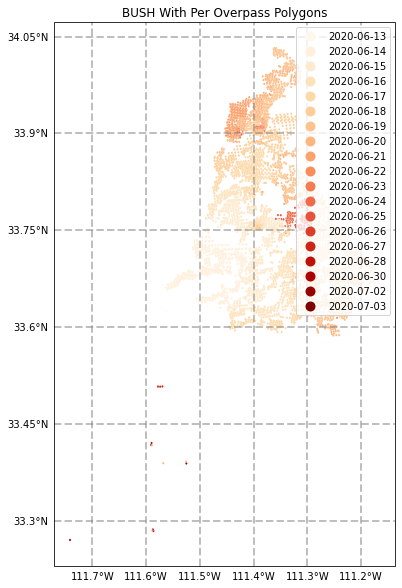

    Incident Number Fire Name Current Day  Current Overpass  Lat Fire  \
0        11721706.0      BUSH  2020-06-13             748.0   33.6257   
1        11721706.0      BUSH  2020-06-14             824.0   33.6257   
2        11721706.0      BUSH  2020-06-14             918.0   33.6257   
3        11721706.0      BUSH  2020-06-14            1006.0   33.6257   
4        11721706.0      BUSH  2020-06-14            1948.0   33.6257   
..              ...       ...         ...               ...       ...   
76       11721706.0      BUSH  2020-06-28            2112.0   33.6257   
77       11721706.0      BUSH  2020-06-30             824.0   33.6257   
78       11721706.0      BUSH  2020-06-30             918.0   33.6257   
79       11721706.0      BUSH  2020-07-02            1954.0   33.6257   
80       11721706.0      BUSH  2020-07-03            2118.0   33.6257   

    Lon Fire  Number of NEW VIIRS points  NEW FRP  \
0   -111.562                         0.0     0.00   
1   -111.562     

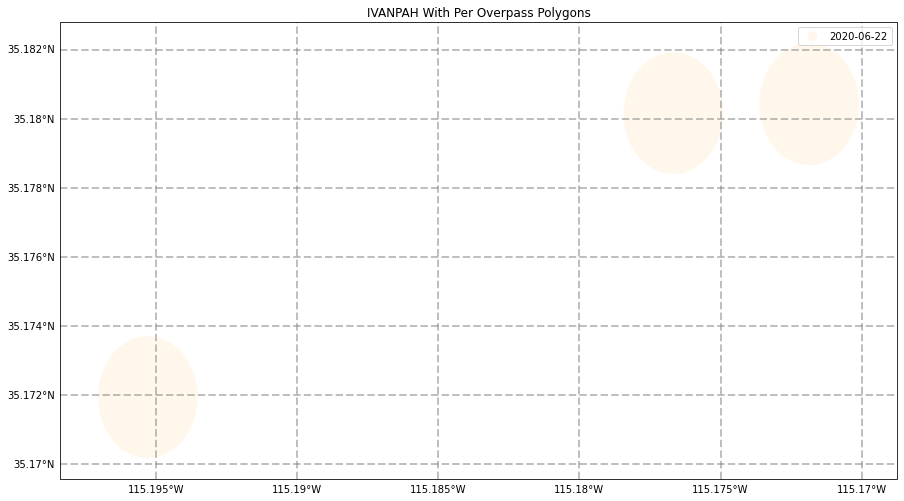

   Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
0       11722418.0   IVANPAH  2020-06-22             736.0  35.171944   
1       11722418.0   IVANPAH  2020-06-22            2124.0  35.171944   

     Lon Fire  Number of NEW VIIRS points  NEW FRP  \
0 -115.195278                         0.0     0.00   
1 -115.195278                         2.0    35.71   

                                            geometry  daily_area  
0  POLYGON ((3961304.147 254990.550, 3961295.961 ...   28.268935  
1  MULTIPOLYGON (((3963812.558 255113.322, 396380...   56.525634  
LUMP GULCH
<class 'str'>
0
['2020-06-13' '2020-06-14' '2020-06-15' '2020-06-16' '2020-06-17'
 '2020-06-18' '2020-06-19' '2020-06-20' '2020-06-21' '2020-06-22'
 '2020-06-23' '2020-06-24' '2020-06-25' '2020-06-26' '2020-06-27'
 '2020-06-28' '2020-06-29']
2020-06-13
2020-06-14
2020-06-15
2020-06-16
2020-06-17
2020-06-18
2020-06-19
2020-06-20
2020-06-21
2020-06-22
2020-06-23
2020-06-24
2020-06-25
2020-06-26
2020-06-2

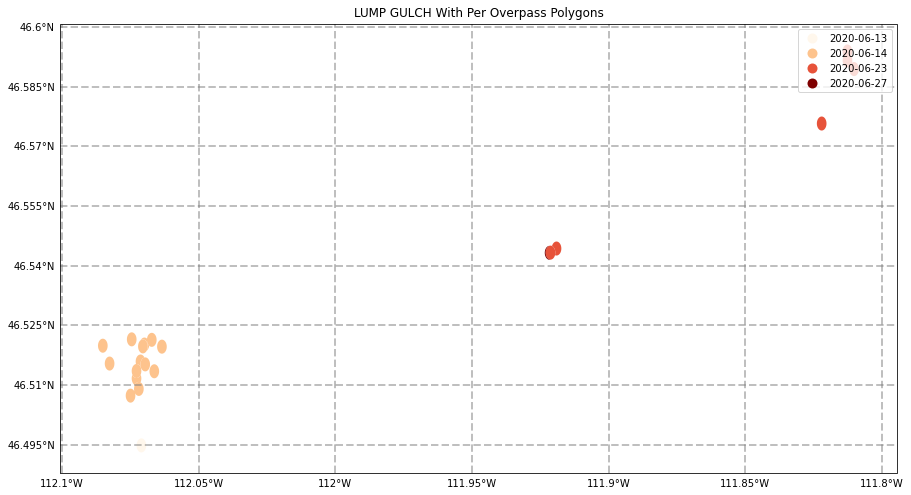

   Incident Number   Fire Name Current Day  Current Overpass  Lat Fire  \
0       11723044.0  LUMP GULCH  2020-06-13             748.0  46.49479   
1       11723044.0  LUMP GULCH  2020-06-14             824.0  46.49479   
2       11723044.0  LUMP GULCH  2020-06-14            1006.0  46.49479   
3       11723044.0  LUMP GULCH  2020-06-23             854.0  46.49479   
4       11723044.0  LUMP GULCH  2020-06-23             942.0  46.49479   
5       11723044.0  LUMP GULCH  2020-06-23            1930.0  46.49479   
6       11723044.0  LUMP GULCH  2020-06-23            2018.0  46.49479   
7       11723044.0  LUMP GULCH  2020-06-27             918.0  46.49479   

   Lon Fire  Number of NEW VIIRS points  NEW FRP  \
0 -112.0709                         0.0     0.00   
1 -112.0709                        11.0    35.60   
2 -112.0709                         3.0     3.80   
3 -112.0709                         1.0     0.60   
4 -112.0709                         1.0     0.61   
5 -112.0709          

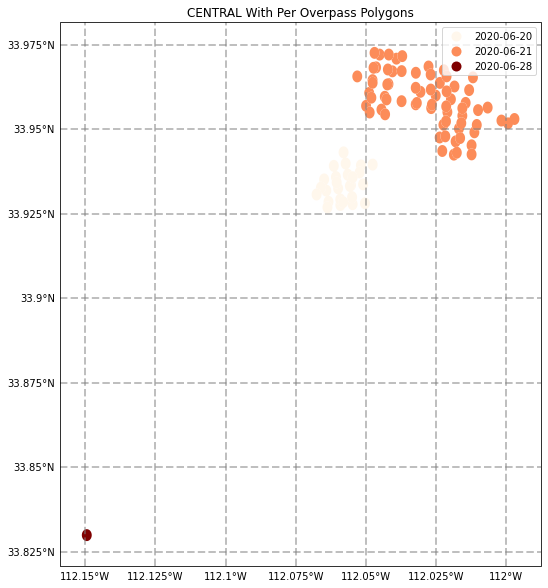

   Incident Number Fire Name Current Day  Current Overpass  Lat Fire  \
0       11723968.0   CENTRAL  2020-06-20             812.0  33.93066   
1       11723968.0   CENTRAL  2020-06-20            1930.0  33.93066   
2       11723968.0   CENTRAL  2020-06-20            2024.0  33.93066   
3       11723968.0   CENTRAL  2020-06-20            2112.0  33.93066   
4       11723968.0   CENTRAL  2020-06-21             842.0  33.93066   
5       11723968.0   CENTRAL  2020-06-21             936.0  33.93066   
6       11723968.0   CENTRAL  2020-06-21            2054.0  33.93066   
7       11723968.0   CENTRAL  2020-06-28             906.0  33.93066   

   Lon Fire  Number of NEW VIIRS points  NEW FRP  \
0 -112.0676                         0.0     0.00   
1 -112.0676                         5.0   131.00   
2 -112.0676                        13.0   186.29   
3 -112.0676                         7.0   107.70   
4 -112.0676                        32.0   263.62   
5 -112.0676                        32.0

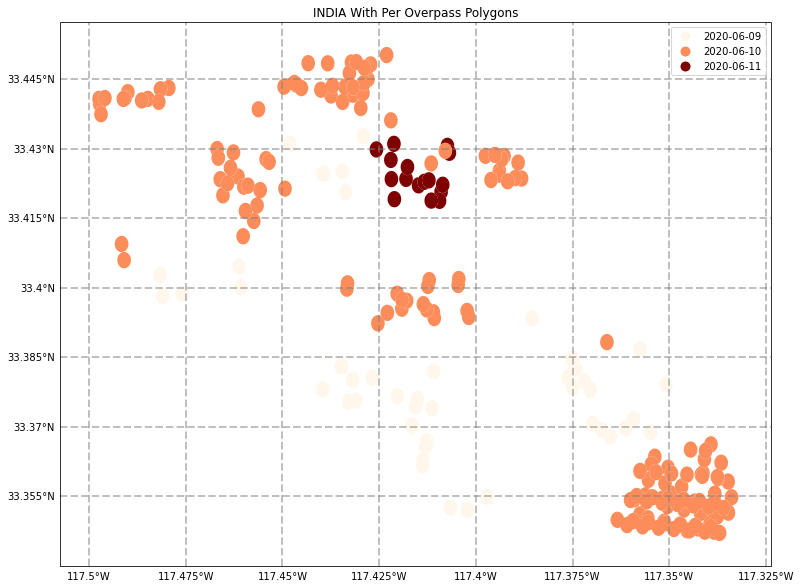

    Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
0        11724173.0     INDIA  2020-06-09             730.0  33.379167   
1        11724173.0     INDIA  2020-06-09             912.0  33.379167   
2        11724173.0     INDIA  2020-06-09            1000.0  33.379167   
3        11724173.0     INDIA  2020-06-09            2030.0  33.379167   
4        11724173.0     INDIA  2020-06-09            2118.0  33.379167   
5        11724173.0     INDIA  2020-06-10             848.0  33.379167   
6        11724173.0     INDIA  2020-06-10             942.0  33.379167   
7        11724173.0     INDIA  2020-06-10            1030.0  33.379167   
8        11724173.0     INDIA  2020-06-10            2012.0  33.379167   
9        11724173.0     INDIA  2020-06-10            2100.0  33.379167   
10       11724173.0     INDIA  2020-06-10            2148.0  33.379167   
11       11724173.0     INDIA  2020-06-11             830.0  33.379167   
12       11724173.0     INDIA  2020-06

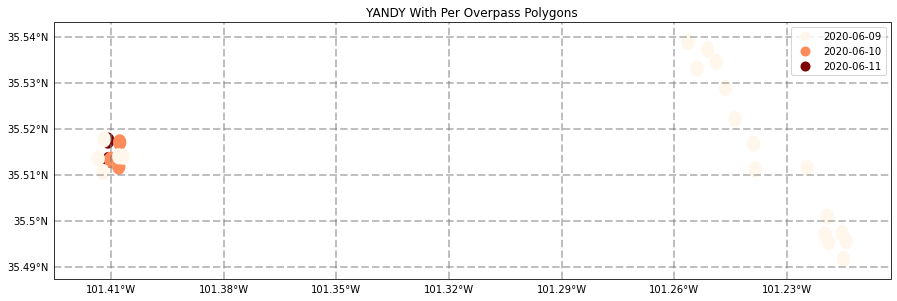

    Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
0        11724284.0     YANDY  2020-06-09             730.0  35.537222   
1        11724284.0     YANDY  2020-06-09             818.0  35.537222   
2        11724284.0     YANDY  2020-06-09             906.0  35.537222   
3        11724284.0     YANDY  2020-06-09            1848.0  35.537222   
4        11724284.0     YANDY  2020-06-09            1936.0  35.537222   
5        11724284.0     YANDY  2020-06-09            2030.0  35.537222   
6        11724284.0     YANDY  2020-06-10             800.0  35.537222   
7        11724284.0     YANDY  2020-06-10             848.0  35.537222   
8        11724284.0     YANDY  2020-06-10            2012.0  35.537222   
9        11724284.0     YANDY  2020-06-11             742.0  35.537222   
10       11724284.0     YANDY  2020-06-11             830.0  35.537222   
11       11724284.0     YANDY  2020-06-11             924.0  35.537222   

      Lon Fire  Number of NEW VIIRS p

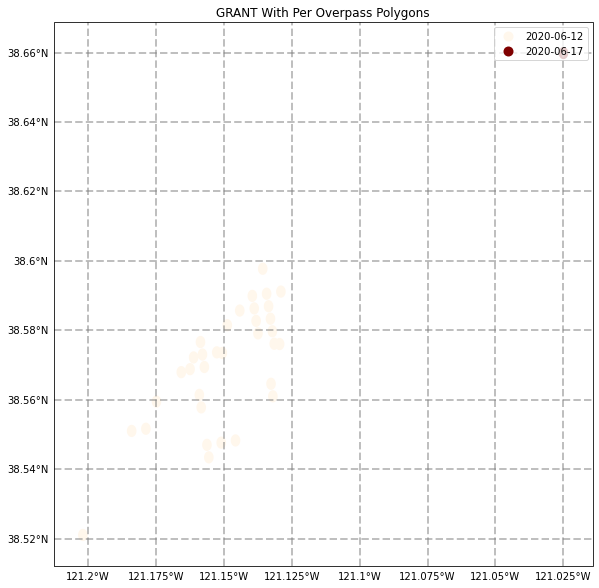

   Incident Number Fire Name Current Day  Current Overpass   Lat Fire  \
0       11724646.0     GRANT  2020-06-12             806.0  38.521111   
1       11724646.0     GRANT  2020-06-12            2112.0  38.521111   
2       11724646.0     GRANT  2020-06-17            2118.0  38.521111   

     Lon Fire  Number of NEW VIIRS points  NEW FRP  \
0 -121.201944                         0.0     0.00   
1 -121.201944                        33.0  1417.90   
2 -121.201944                         1.0     6.43   

                                            geometry  daily_area  
0  POLYGON ((3597949.877 846723.964, 3597940.179 ...   25.916640  
1  MULTIPOLYGON (((3607596.075 851089.165, 360758...  837.338731  
2  POLYGON ((3619714.807 854056.251, 3619705.168 ...   25.823235  
MANGUM
<class 'str'>
0
['2020-06-09' '2020-06-10' '2020-06-11' '2020-06-12' '2020-06-13'
 '2020-06-14' '2020-06-15' '2020-06-16' '2020-06-17' '2020-06-18'
 '2020-06-19' '2020-06-20' '2020-06-21' '2020-06-22' '2020-06-23'
 

KeyboardInterrupt: 

In [20]:
#ALL PER OVERPASS FOR NOW

incident_numbers = incidents_all['Incident Number'].values
print(incident_numbers)
fire_poly_timeseries_all = gpd.GeoDataFrame()

for ii in range(len(incidents_all)):
    print(incidents_all['Fire Name'].iloc[ii])
    
    inci = incidents_all[incidents_all['Incident Number']==incident_numbers[ii]].iloc[0]
    df_save_size = count_overpasses(inci,viirs_all) #count the overpasses between fire start and end date
    
    area = 0
    final_area = inci['Final Area (ac)']
    idx = 0
    radii_test = [0.01,0.05,0.1,0.25]
    #radii_test=[0.1]
    
    while (area<0.75*final_area) & (idx<len(radii_test)):
        print(idx)
        rad_test = radii_test[idx]
        fire_poly_timeseries = build_polygon_timeseries(df_save_size,inci,rad_test)

        if len(fire_poly_timeseries)>0:

            fire_poly_timeseries.crs = "EPSG:4326"
            fire_poly_timeseries = fire_poly_timeseries.to_crs(epsg=3347) #put into lambert conformal conic

            #make sure the returned polygons are valid
            fire_poly_timeseries['geometry'] = fire_poly_timeseries['geometry'].buffer(0)
            #fire_poly_timeseries['geometry'] = fire_poly_timeseries['geometry'].apply(lambda x: shapely.wkt.loads(shapely.wkt.dumps(x, rounding_precision=3)))
            fire_poly_timeseries['geometry'].apply(lambda z: print(explain_validity(z)))
            fire_poly_timeseries['geometry'] = fire_poly_timeseries['geometry'].apply(lambda y: make_valid(y))
            fire_poly_timeseries['daily_area'] = fire_poly_timeseries.area/4047 #area in acres
            
            area=fire_poly_timeseries['daily_area'].sum()
            idx=idx+1
            print(area, final_area)
    
    fire_poly_timeseries_plot = fire_poly_timeseries.to_crs('EPSG:4326')

    fig = plt.figure(figsize=(15,10))
    ax= fig.add_subplot(111,projection=ccrs.PlateCarree())
    #ax.set_extent([-124, -122, 39.2,40.5])
    fire_poly_timeseries_plot.plot(column = fire_poly_timeseries['Current Day'], ax=ax, cmap='OrRd', legend=True)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,\
                        linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    plt.title(incidents_all['Fire Name'].iloc[ii]+ ' With Per Overpass Polygons')
    plt.show()

    #fire_poly_timeseries.set_geometry(col='geometry', inplace=True) #assign a column to represent geometry
    #fire_poly_timeseries.to_file(fire_incidents[ii].lower().replace(' ', '_')+'_VIIRS_per_overpass_2.geojson', driver='GeoJSON')

    print(fire_poly_timeseries)
    fire_poly_timeseries_all = pd.concat([fire_poly_timeseries_all, fire_poly_timeseries],axis=0)
fire_poly_timeseries_all.to_file('AllFires_VIIRS_per_overpass_2020.geojson', driver='GeoJSON')


# Helper Functions

In [7]:
#function to get the size of the resulting dataframe
#IN: incidents=the summary table of the incidents (only one incident at a time)
#IN: viirs_all= table of all VIIRS detects
#OUT: df_size= the number of satellite overpasses between start and end times of fire in UTC
def count_overpasses(incidents,viirs_all):
    df_size = 0
    #start and end times of the fire in UTC
    print(type(incidents['First Day UTC']))
    inci_start = np.datetime64(incidents['First Day UTC'], 'D')
    inci_end = np.datetime64(incidents['Last Day UTC'],'D') 

    #how many overpass times are between the start and end time of this fire?
    inds_fire = np.where((viirs_all['acq_date'].iloc[:]>=str(inci_start))\
                                    & (viirs_all['acq_date'].iloc[:]<=str(inci_end)))[0]
    viirs_fire = viirs_all.iloc[inds_fire]
    dates = np.unique(viirs_fire['acq_date'])
    for day in dates:
        viirs_sub = viirs_fire.iloc[np.where(viirs_fire['acq_date']==day)[0]]
        df_size = df_size + len(np.unique(viirs_sub['acq_time']))
    return df_size

In [8]:
def build_polygon_timeseries(df_size,incidents,rad):
    fire_series_new = gpd.GeoDataFrame({'Incident Number': np.nan*np.zeros(df_size), 
                                        'Fire Name': np.nan*np.zeros(df_size), 
                                        'Current Day': np.nan*np.zeros(df_size),
                                        'Current Overpass': np.nan*np.zeros(df_size),
                                        'Lat Fire': np.nan*np.zeros(df_size), 
                                        'Lon Fire': np.nan*np.zeros(df_size), 
                                        'Number of NEW VIIRS points': np.nan*np.zeros(df_size), 
                                        'NEW FRP': np.nan*np.zeros(df_size),
                                        'geometry': np.nan*np.zeros(df_size)}) # pre-allocate the dataframe

    fire_series_cumu = gpd.GeoDataFrame({'Incident Number': np.nan*np.zeros(df_size), 
                                        'Fire Name': np.nan*np.zeros(df_size), 
                                        'Current Day': np.nan*np.zeros(df_size),
                                        'Current Overpass': np.nan*np.zeros(df_size),
                                        'Lat Fire': np.nan*np.zeros(df_size), 
                                        'Lon Fire': np.nan*np.zeros(df_size), 
                                        'Number of TOTAL VIIRS points': np.nan*np.zeros(df_size), 
                                        'NEW FRP': np.nan*np.zeros(df_size),
                                        'geometry': np.nan*np.zeros(df_size)}) # pre-allocate the dataframe
    count = 0
    #start and end times of the fire in UTC
    inci_start = np.datetime64(incidents['First Day UTC'], 'D')
    inci_end = np.datetime64(incidents['Last Day UTC'], 'D') 
    
    lat_fire = incidents['Lat Fire']
    lon_fire = incidents['Lon Fire']
    #print(lon_fire, lat_fire)
    
    #pt_start = Point(lon_fire, lat_fire)
    #pt_start = pt_start.buffer(0.04)
    lat_old = np.array([lat_fire])
    lon_old = np.array([lon_fire])
    #name = incidents['Fire Name']
    #print(name)
    inds_fire = np.where((viirs_all['acq_date'].iloc[:]>=str(inci_start))\
                                   & (viirs_all['acq_date'].iloc[:]<=str(inci_end)))[0]
    viirs_fire = viirs_all.iloc[inds_fire]
    dates = np.unique(viirs_fire['acq_date'])
    print(dates)
    
    tic=np.datetime64('now') #to time how long the code takes
   
    for day in dates: #loop over the days
        print(day)
        viirs_day = viirs_fire.iloc[np.where(viirs_fire['acq_date']==day)[0]]
        overpasses = np.unique(viirs_day['acq_time'])
        
        for over in overpasses: #loop over the overpasses
            #print(over)
            viirs_over = viirs_day.iloc[np.where(viirs_day['acq_time']==over)[0]] # all points associated with an overpass
            lat = viirs_over['latitude'].values
            lon = viirs_over['longitude'].values
            viirs_tups = [list((lon[i], lat[i])) for i in range(len(lat))]
    
            poly_lats, poly_lons = build_today_polygon(lat, lon, lat_old, lon_old, rad)
        
            #get the new points and the cumulative points
            #poly_tups_cumulative = [list((lon_cumulative[i], lat_cumulative[i])) for i in range(len(lon_cumulative))]
            poly_tups_new = [list((poly_lons[i], poly_lats[i])) for i in range(len(poly_lons))]
            
            
            if day==dates[0] and over==overpasses[0]: #if it's the first day of the fire
                #get the cumulative stuff 
                lat_cumulative = np.append(lat_old, poly_lats)
                lon_cumulative = np.append(lon_old, poly_lons)
                poly_tups_cumulative = [list((lon_cumulative[i], lat_cumulative[i])) for i in range(len(lon_cumulative))]
                inds_new_points = [kk for kk in range(len(lat)) if viirs_tups[kk] in poly_tups_cumulative] #inds where we grab FRP
                frp =  np.sum(viirs_over['frp'].iloc[inds_new_points])
                #make a shape around the cumulative points, buffer by 300m (0.0027027 degrees ~0.003 degrees) NEED TO DIVIDE BY 2
                shape_new_save = MultiPoint(poly_tups_cumulative).buffer(0.001763092448)#.convex_hull #the full shape so far
                fire_series_new.iloc[count] = [incidents['Incident Number'],\
                                       incidents['Fire Name'],\
                                       day, over,\
                                    lat_fire, lon_fire, len(poly_tups_new),\
                                      frp, shape_new_save]
                fire_series_cumu.iloc[count] = [incidents['Incident Number'],\
                                       incidents['Fire Name'],\
                                       day, over, \
                                    lat_fire, lon_fire, len(poly_tups_new),\
                                      frp, shape_new_save]     
                    
                count=count+1
                
            elif len(poly_tups_new)!=0: #if we are adding new points
                inds_new_points = [kk for kk in range(len(lat)) if viirs_tups[kk] in poly_tups_new] #inds where we grab FRP
                frp =  np.sum(viirs_over['frp'].iloc[inds_new_points])
                shape_new = MultiPoint(poly_tups_new).buffer(0.001763092448)
                shape_cumu = fire_series_cumu['geometry'].iloc[count-1]
                shape_new_save = shape_new.difference(shape_cumu)
                fire_series_new.iloc[count] = [incidents['Incident Number'],\
                                       incidents['Fire Name'],\
                                       day, over, \
                                               lat_fire, lon_fire, len(poly_tups_new),\
                                      frp, shape_new_save]
                fire_series_cumu.iloc[count] = [incidents['Incident Number'],\
                                       incidents['Fire Name'],\
                                       day, over,  \
                                               lat_fire, lon_fire, len(poly_tups_new),\
                                      frp, shape_new.union(shape_cumu)]     
                    
                count=count+1
                
            lat_cumulative = np.append(lat_old, poly_lats)
            lon_cumulative = np.append(lon_old, poly_lons)
            lat_old=lat_cumulative
            lon_old=lon_cumulative
            
    
    toc = np.datetime64('now') #to time how long the code takes
    print(str(toc-tic)+' seconds elapsed')
    
    #drop null geometries
    fire_series_new = fire_series_new.drop(np.where(fire_series_new['geometry']==None)[0])

    return fire_series_new

In [9]:
#lat_old and lon_old are the detects used to build the prev version of today's polygon
def build_today_polygon(lats, lons, lats_old, lons_old, bf):
    tups_old = [list((lons_old[i], lats_old[i])) for i in range(len(lats_old))]
    shape_old_buff = MultiPoint(tups_old).convex_hull.buffer(bf)
    
    #find the points that are inside the buffer
    pairs = zip(lons, lats)
    lat_new = []
    lon_new = []
    
    xs, ys = shape_old_buff.exterior.xy #get the edges of the buffered shape
    poly_path = Path(np.stack([xs, ys], axis=1)) #make them into a path
    poly_path_contains = poly_path.contains_points(np.stack([lons,lats],axis=1)) #get the points that are in the shape REPLACES FOR LOOP

    #grab the new points
    lat_new =lats[np.where(poly_path_contains==True)[0]]
    lon_new =lons[np.where(poly_path_contains==True)[0]]


    if (len(lat_new)-len(lats_old))>0: #if we are adding points 
        #print('Time for recursive call')
        return build_today_polygon(lats, lons, lat_new, lon_new, bf)
    else:
        return lat_new, lon_new #MAY WANT TO RETURN A BUFFERED VERSION OF THE POLYGON
    

In [10]:
#uses max to combine the polygons, day starts at day_start_hour
def combine_per_overpass_polygons_to_daily(fire, day_start_hour):
    # load in the PER OVERPASS polygons and attributes
    per_overpass_fire = gpd.read_file('./fire_polygons/'+fire.lower().replace(' ','_')+'_VIIRS_per_overpass.geojson') #polygons only

    daystrings = [per_overpass_fire['Current Day'].iloc[i]  for i in range(len(per_overpass_fire))]
    timestrings = [str(int(per_overpass_fire['Current Overpass'].iloc[i])).zfill(4) for i in range(len(per_overpass_fire))]

    datetime_strings = [daystrings[i]+'T'+timestrings[i][0:2]+':'+timestrings[i][2:4] for i in range(len(per_overpass_fire))]
    datetimes = np.array(datetime_strings,dtype='datetime64')

    current_day = [] #if observed hour>day_start_hour, current day, else previous day
    for ii in range(len(datetimes)):
        time_compare = np.datetime64(daystrings[ii]+'T'+str(day_start_hour).zfill(2)+':00')
        if datetimes[ii]>= time_compare:
            current_day.append(daystrings[ii])
        else:
            current_day.append(str(np.datetime64(daystrings[ii])-np.timedelta64(1,'D')))
    print(current_day)
    per_overpass_fire['Local Day'] = current_day
    tic = np.datetime64('now')
    daily_fire_dataframe = per_overpass_fire.dissolve(by='Local Day', aggfunc='max',as_index=False)
    toc = np.datetime64('now')
    print(toc-tic)
    
    return daily_fire_dataframe

## Testing

In [ ]:
fire = 'LAKE'
fire_daily = combine_per_overpass_polygons_to_daily(fire,12)
print(fire_daily)

In [ ]:
#uses max to combine the polygons
def combine_per_overpass_polygons_to_daily_old(fire):
    print(fire.upper(), fire.lower())
    # load in the PER OVERPASS polygons and attributes
    per_overpass_fire = gpd.read_file(fire.lower().replace(' ','_')+'_VIIRS_per_overpass.geojson') #polygons only
    fire_inds = np.where(per_overpass_fire['Fire Name']==fire.upper())[0];
    
    datestrings = [per_overpass_fire['Current Day'].iloc[i]+ ' '+\
               str(int(per_overpass_fire['Current Overpass'].iloc[i])).zfill(4) for i in range(len(fire_inds))]
    
    tic = np.datetime64('now')
    daily_fire_dataframe = per_overpass_fire.dissolve(by='Current Day', aggfunc='max',as_index=False)
    toc = np.datetime64('now')
    print(toc-tic)
    
    return daily_fire_dataframe

In [ ]:
df_lake_new = gpd.read_file('lake_VIIRS_per_overpass_2.geojson')
df_lake_new.plot()

In [ ]:
df_lake= gpd.read_file('./fire_polygons/lake_VIIRS_per_overpass.geojson')
df_lake.plot()